# Setting Up the Problem

#### Objective: Understand and establish the baseline for your chosen dataset

In [3]:
import datasets
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

## OWN FUNCTIONS
#import support_functions
#from support_functions import *

In [4]:
### Support Functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
import spacy

#python -m spacy download en_core_web_sm - Run on Terminal
nlp = spacy.load("en_core_web_sm")

# Create a new Matcher
matcher = Matcher(nlp.vocab)


## Class Proportion

def class_prop(label):
    train_class = pd.Series(label).value_counts().reset_index()
    #Rename columns
    train_class.columns = ['class', 'count']
    train_class['total'] = train_class['count'].sum()
    train_class['perc'] = train_class['count']/train_class['total']
    print(train_class[['class','count','perc']].round(4))


## Function for Based-Rule classifier
def classify_text(text):
    doc = nlp(text)
    matches = matcher(doc)
    if matches:
        return matches  # Return the label of the first match
    else:
        return "UNKNOWN"  # If no match found


## Plot Metric Results

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


### DATA EXPLORATION
        
def freq_table(df,label):
    train_class = df[label].value_counts().reset_index()
    #Rename columns
    train_class.columns = ['category', 'count']
    train_class['total'] = train_class['count'].sum()
    train_class['perc'] = train_class['count']/train_class['total']
    return train_class[['category','count','perc']].round(4)

In [5]:
df = load_dataset("carblacac/twitter-sentiment-analysis")

/Users/mikelgallo/anaconda3/envs/text_2/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for carblacac/twitter-sentiment-analysis contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/carblacac/twitter-sentiment-analysis
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


### Characteristics of the dataset

**b. Dataset Description (0.5 points): Provide a brief overview of your dataset, including size, class distribution, and any peculiar characteristics. Include basic descriptive statistics.**

##### TSATC: Twitter Sentiment Analysis Training Corpus     
Original DATASET contains 1,578,627 classified tweets (1 for positive and 0 for negative sentiment).

Our dataset has already been randomly sampled, cleaned, and split into training and testing sets. Both positive and negative classes are well balanced within each subset, and the training subset has been further divided into an 80% training set and a 20% validation set.  

This dataset is an aggregation of two twitter sentiment analysis datasets:  
- University of Michigan Sentiment Analysis competition on Kaggle: https://inclass.kaggle.com/c/si650winter11  
- Twitter Sentiment Corpus by Niek Sanders: http://www.sananalytics.com/lab/twitter-sentiment/

  
Languages: English

In [6]:
import random

## Defining train, validation and test sets
train_data = df['train']['text']
train_labels = df['train']['feeling']

validation_data = df['validation']['text']
validation_labels = df['validation']['feeling']

test_data = df['test']['text']
test_labels = df['test']['feeling']


# Define the percentage of data to use
sample_percentage = 0.3

# Sample 30% of the train data
sample_size = int(len(train_data) * sample_percentage)
train_sample_indices = random.sample(range(len(train_data)), sample_size)
train_data = [train_data[i] for i in train_sample_indices]
train_labels = [train_labels[i] for i in train_sample_indices]

# Sample 30% of the validation data
sample_size = int(len(validation_data) * sample_percentage)
validation_sample_indices = random.sample(range(len(validation_data)), sample_size)
validation_data = [validation_data[i] for i in validation_sample_indices]
validation_labels = [validation_labels[i] for i in validation_sample_indices]

# Sample 30% of the test data
sample_size = int(len(test_data) * sample_percentage)
test_sample_indices = random.sample(range(len(test_data)), sample_size)
test_data = [test_data[i] for i in test_sample_indices]
test_labels = [test_labels[i] for i in test_sample_indices]


## Creating Dataframes
df_train = pd.DataFrame({'text':train_data,'label':train_labels})
df_val = pd.DataFrame({'text':validation_data,'label':validation_labels})
df_test = pd.DataFrame({'text':test_data,'label':test_labels})

df

DatasetDict({
    train: Dataset({
        features: ['text', 'feeling'],
        num_rows: 119988
    })
    validation: Dataset({
        features: ['text', 'feeling'],
        num_rows: 29997
    })
    test: Dataset({
        features: ['text', 'feeling'],
        num_rows: 61998
    })
})

### Dataset size

In [7]:
total_rows = len(train_labels) + len(test_labels) + len(validation_labels)
# Calculate train size including validation
Train_size = len(train_labels) + len(validation_labels)
# Calculate Summary
summary_df = pd.DataFrame({'SET': ['TRAIN','TEST', 'TOTAL'], 'ROWS': [Train_size, len(test_labels), total_rows], 'SPLIT': [Train_size/total_rows, len(test_labels)/total_rows,total_rows/total_rows]})
print('Dataset Split [TRAIN, TEST]')
display(summary_df.round(3))

## TRAIN SPLIT
summary_df_train = pd.DataFrame({'SET': ['train','validation', 'TRAIN'], 'ROWS': [len(train_labels), len(validation_labels), Train_size], 'SPLIT': [len(train_labels)/Train_size, len(validation_labels)/Train_size,Train_size/Train_size]})
print('TRAIN Split [train, validation]')
display(summary_df_train.round(3))

Dataset Split [TRAIN, TEST]


,SET,ROWS,SPLIT
0,TRAIN,44995,0.708
1,TEST,18599,0.292
2,TOTAL,63594,1.000


TRAIN Split [train, validation]


,SET,ROWS,SPLIT
0,train,35996,0.8
1,validation,8999,0.2
2,TRAIN,44995,1.0


### Class distribution

In [8]:
## Class balance of our datasets
print('train')
class_prop(train_labels)
print('validation')
class_prop(validation_labels)
print('test')
class_prop(test_labels)

train
   class  count    perc
0      1  18020  0.5006
1      0  17976  0.4994
validation
   class  count    perc
0      0   4505  0.5006
1      1   4494  0.4994
test
   class  count    perc
0      0   9358  0.5031
1      1   9241  0.4969


### Distribution of text lengths (train set only)

In [9]:
df_train['text_length']= [len(i.split()) for i in df_train['text']]
df_val['text_length']= [len(i.split()) for i in df_val['text']]
df_test['text_length']= [len(i.split()) for i in df_test['text']]
#Calculating Answer Length

In [10]:
for i in df_train['text'][0:5]:
    print(i.split(),'length: ', len(i.split()) )

["don't", 'you', 'see', 'me', 'on', 'the', 'phone', "don't", 'interrupt', 'rude!', 'se-curity,', 'se-curity!', 'Need', '2', 'go,', 'need', '2', 'go.', 'Wow', 'I', 'should', 'go', 'to', 'bed!', 'but', 'i', "can't!"] length:  27
['@zaibatsu', 'Additionally,', 'I', 'am', 'in', 'mourning.', 'So,', 'please', 'rescind', 'your', 'joke,', 'please.'] length:  12
['faded', 'with', 'the', 'boys,', 'just', 'like', 'old', 'times.', 'beer', 'run?', 'i', 'want', 'to', 'try', 'it..', 'what', 'do', 'you', 'think?'] length:  19
['fighting', 'with', 'layouts', 'in', 'wxhaskell.', "can't", 'make', 'this', 'textCtrl', 'fill', 'the', 'entire', 'vertical', 'space', 'when', 'I', 'resize', 'the', 'window'] length:  19
['Wish', 'i', 'had', 'the', 'day', 'off', '2day.......'] length:  7


Summary Statistics of text_length for positive(1) and negative(0) tweets
            mean  median       std  min  max
label                                       
0      13.723298    13.0  7.055180    1   57
1      12.882630    12.0  6.780664    1   42
   
Plot text_length distribution for positive(1) and negative(0) tweets


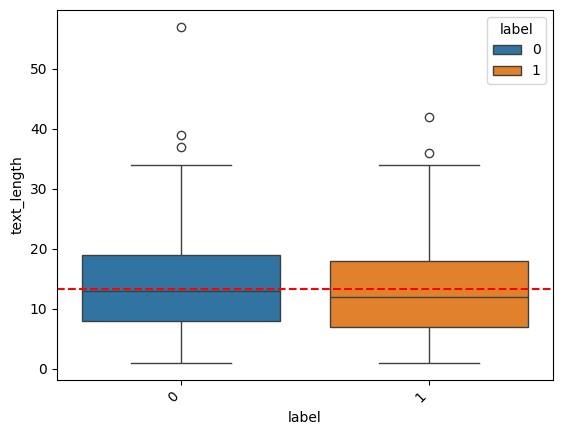

In [11]:
## Summary statistics for text_length
# Calculate multiple statistics
print('Summary Statistics of text_length for positive(1) and negative(0) tweets')
statistics = df_train.groupby('label')['text_length'].agg(['mean', 'median','std', 'min', 'max'])
# Display the result
print(statistics)

print('   ')

print('Plot text_length distribution for positive(1) and negative(0) tweets')
sns.boxplot(data=df_train, x='label', y='text_length',hue = 'label')
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_train['text_length'].mean()
plt.axhline(y=mean_reply_length, color='red', linestyle='--', label=f'Mean text Length ({mean_reply_length:.2f})')
# Show the plot
plt.show()

## Data Cleaning
Twitter text requires multiple transformations prior to Preprocessing

In [12]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons


# Create a TextPreProcessor instance
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used for word segmentation
    segmenter="twitter",
    # corpus from which the word statistics are going to be used for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text, with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons],
    #Remove emoticon
    pre_processor=[lambda x: x.replace('＼(^o^)／', '')]
)

# Pre-process the sentence using TextPreProcessor

def extract_clean(text):
    cleaned_text = ' '.join([word.split('<')[0] for word in text])
    return cleaned_text

def extract_emotions(text):
    emoji_expressions = [token for token in text if token in emoticons.values()]
    return emoji_expressions

def clean_string(text):
    cleaned_text = re.sub(r'\s+', ' ', text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

def flatten_emotions(emotion_list):
    # Convert the list of emotions into a string
    emotion_string = ', '.join(emotion_list)
    # Use regular expression to find all words inside angle brackets
    emotions = re.findall(r'<([^>]*)>', emotion_string)
    unique_emotions = list(set(emotions))
    combined_emotions = ', '.join(unique_emotions)
    return combined_emotions


def clean_text(df):
# Pre-process all the sentences in df_train['text']
    df['preprocessed_text'] = [text_processor.pre_process_doc(text) for text in df['text']]
    df['clean_text'] = df['preprocessed_text'].apply(extract_clean).apply(clean_string)

    #Getting Hashtags
    df['hashtag'] = df['text'].apply(lambda x: re.findall(r'#(\w+)', x))
    df['hashtag'] = [' '.join(i) for i in df['hashtag']]

    # Iterate through the preprocessed text
    df['emotions'] = df['preprocessed_text'].apply(extract_emotions)
    df['clean_emotions'] = df['emotions'].apply(flatten_emotions)

    df = df[['text','label','text_length','clean_text','clean_emotions','hashtag']]
    return df

df_train = clean_text(df_train)
df_val = clean_text(df_val)
df_test = clean_text(df_test)


/Users/mikelgallo/anaconda3/envs/text_2/lib/python3.12/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/Users/mikelgallo/anaconda3/envs/text_2/lib/python3.12/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


## DATA EXPLORATION

#### Hashtags

- 98% of the tweets have no hashtags. Most likely they have been already cleaned.
- Doesn't make sense to keep diving for more insigths.

In [13]:
hashtag_freq = freq_table(df_train,'hashtag')
hashtag_freq = hashtag_freq.sort_values(by='perc',ascending=False)
hashtag_freq['accum'] = hashtag_freq['perc'].cumsum()
print('top 10 hashtags')
display(hashtag_freq[0:10])

top 10 hashtags


,category,count,perc,accum
0,,35203,0.9780,0.9780
2,fb,44,0.0012,0.9792
1,followfriday,44,0.0012,0.9804
3,squarespace,20,0.0006,0.9810
5,1,14,0.0004,0.9814
4,FF,14,0.0004,0.9818
6,ff,6,0.0002,0.9820
7,goodsex,6,0.0002,0.9822
8,iranelection,6,0.0002,0.9824
9,BSB,6,0.0002,0.9826


#### EMOTIONS

- 98% of the tweets have no emotions. Most likely have been already removed.
- Because they directly express the sentiment of the text, we'll concatenate them to our cleaned tweet corpus.

In [14]:
emotions_freq = freq_table(df_train,'clean_emotions')
emotions_freq = emotions_freq.sort_values(by='perc',ascending=False)
emotions_freq['accum'] = emotions_freq['perc'].cumsum()
print('top 10 emotions')
display(emotions_freq[0:10])

top 10 emotions


,category,count,perc,accum
0,,35203,0.9780,0.9780
1,wink,187,0.0052,0.9832
2,annoyed,177,0.0049,0.9881
3,laugh,106,0.0029,0.9910
4,sad,105,0.0029,0.9939
5,happy,81,0.0023,0.9962
6,tong,61,0.0017,0.9979
7,surprise,49,0.0014,0.9993
8,kiss,9,0.0003,0.9996
12,"happy, wink",2,0.0001,0.9997


In [15]:
#Concatenate text with emotions
df_train['text_emotion'] = df_train['clean_text']+' '+df_train['clean_emotions']
df_val['text_emotion'] = df_val['clean_text']+' '+df_val['clean_emotions']
df_test['text_emotion'] = df_test['clean_text']+' '+df_test['clean_emotions']


### Preprocessor

In [16]:
#Defining preprocessing class to be included in Pipeline later.
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import string
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


## Text mining - Preprocessing, CountVectorizing and tf-idf

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.punctuations = set(string.punctuation)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_texts = []
        for text in X:
            # Convert text to lowercase
            #text = text.lower()
            text = "".join([char.lower() for char in text if char not in string.punctuation]) 
            # Tokenize text
            tokens = word_tokenize(text)
            # Remove stopwords and apply lemmatization
            filtered_tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word not in self.stop_words]
            # Join tokens back into a string
            preprocessed_text = ' '.join(filtered_tokens)
            preprocessed_texts.append(preprocessed_text)

        return preprocessed_texts


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mikelgallo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikelgallo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mikelgallo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
sent = ['hello . ! my name is! test .. wuhoo']
pre =TextPreprocessor()
pre.fit(sent)
res = pre.transform(sent)
res

['hello name test wuhoo']

#### Exploring positive and negative words using WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikelgallo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


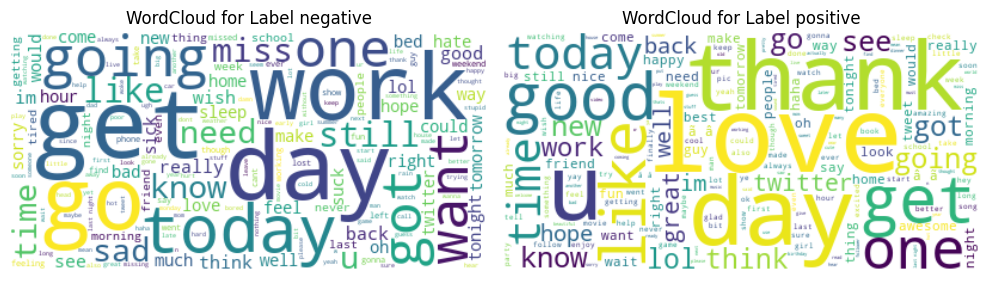

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


labels = {0: 'negative', 1: 'positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(df_train['clean_text'], df_train['label']):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

## Exploring positive and negative words using TF-IDF + LDA

In [19]:
## Preprocessing texts
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the pipeline on the training data
pipeline.fit(df_train['clean_text'])



Pipeline(steps=[('prepro', TextPreprocessor()),
                ('vect',
                 CountVectorizer(max_df=0.97, min_df=0.005,
                                 ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(norm='l1'))])

### TF-IDF Score

In [20]:
def tfidf_term(pipeline,df,sentiment):
# Access the CountVectorizer step from the pipeline
    count_vectorizer = pipeline.named_steps['vect']
    # Fit and transform the data
    tf_idf_pos_matrix = pipeline.transform(df[df['label']==sentiment]['clean_text'])
    # Convert count matrix to DataFrame
    vec_fr_mtx = pd.DataFrame(data=tf_idf_pos_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

    #Creating a dictionary of frequencies for our terms
    feature_names = count_vectorizer.get_feature_names_out()
    # Calculate Term frequency dictionary
    term_tfidf = np.mean(vec_fr_mtx, axis=0)
    #Store in a dictionary
    tfidf_dict = {i: n for i, n in zip(feature_names, term_tfidf)}
    print(len(term_tfidf))
    return feature_names, term_tfidf, tfidf_dict


def transform_to_dataframe(feature_names, score):
    # Create DataFrame with feature names and mean TF-IDF scores
    df = pd.DataFrame({'terms': feature_names, 'score': score})
    # Reset index
    df.reset_index(drop=True, inplace=True)
    return df

# Example usage:
def plot_freq_top(df,top,pos):
    df = df.sort_values(by='score',ascending = False)
    df = df.head(top)
    #We are going to set the

    # Plot the top N terms and their TF-IDF scores
    plt.figure(figsize=(10, 6))
    plt.barh(df['terms'], df['score'], align='center')
    plt.yticks(df['terms'])
    plt.xlabel('Frequency Score')
    plt.title(pos.format(top))
    #plt.xlim(0,0.010)
    plt.gca().invert_yaxis()  # Invert y-axis to display top terms at the top
    plt.show()

238


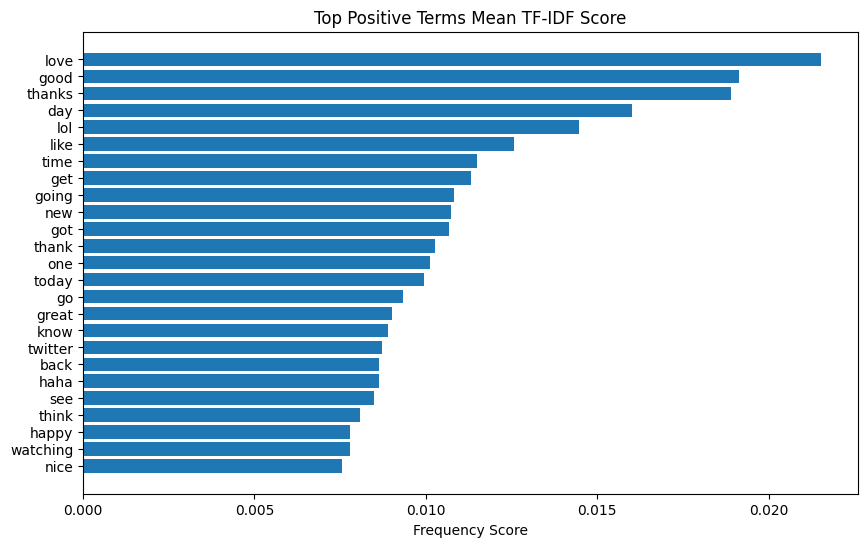

In [21]:
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train,1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

238


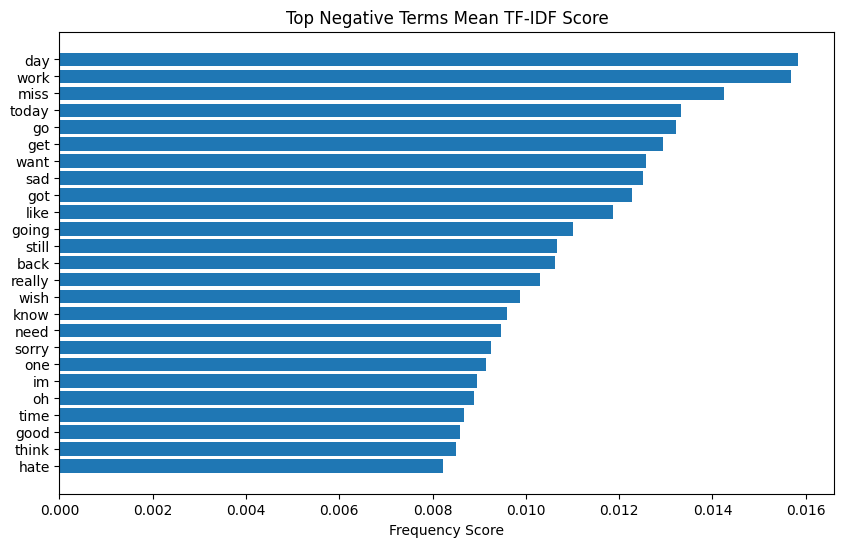

In [22]:
neg = f'Top Negative Terms Mean TF-IDF Score'
## Posive Terms
neg_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train,0)
neg_tf_idf = transform_to_dataframe(neg_feature_names,term_tfidf)
plot_freq_top(neg_tf_idf,25,neg)

### Analyzing Both Positive and Negative Most Common Topics

In [23]:
from sklearn.decomposition import LatentDirichletAllocation
# Specify the number of topics (adjust as needed)
num_topics = 10
# Initialize LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

##Creating matrix
tf_idf_pos_matrix = pipeline.transform(df_train[df_train['label']==1]['clean_text'])
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_pos_matrix.toarray(), columns=pos_feature_names)

# Fit the model to your TF-IDF matrix
lda.fit(tfidf_mtx)

LatentDirichletAllocation(random_state=42)

In [24]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


# Print top words for each topic
print_top_words(lda, pos_feature_names, n_top_words=10)

Topic #1: thanks, new, haha, got, morning, yay, back, always, well, good
Topic #2: day, good, today, tweet, getting, little, everyone, beautiful, school, life
Topic #3: nice, think, say, see, need, friend, want, done, finally, made
Topic #4: right, come, movie, glad, tonight, ok, watch, still, lunch, working
Topic #5: happy, fun, yeah, oh, like, birthday, girl, go, first, people
Topic #6: love, hey, know, guy, really, please, also, omg, weekend, live
Topic #7: twitter, watching, awesome, follow, best, would, show, game, friday, luck
Topic #8: thank, yes, time, song, amazing, hi, keep, music, party, video
Topic #9: lol, going, cool, look, wait, way, take, better, next, could
Topic #10: great, night, im, one, get, sure, looking, let, sweet, check


In [25]:
def get_top_words(model, feature_names, n_top_words):
    top_words_per_topic = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# Get top words for each topic
top_words_per_topic = get_top_words(lda, pos_feature_names, n_top_words=10)
# Extract words from list of lists
top_pos_words = [word for sublist in top_words_per_topic for word in sublist]

# Remove duplicates using set()
unique_pos = set(top_pos_words)

In [26]:
# Specify the number of topics (adjust as needed)
num_topics = 10
# Initialize LDA model
lda2 = LatentDirichletAllocation(n_components=num_topics, random_state=42)

##Creating matrix
tf_idf_neg_matrix = pipeline.transform(df_train[df_train['label']==0]['clean_text'])
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_neg_matrix.toarray(), columns=neg_feature_names)

# Fit the model to your TF-IDF matrix
lda2.fit(tfidf_mtx)

LatentDirichletAllocation(random_state=42)

In [27]:
# Print top words for each topic
print_top_words(lda2, neg_feature_names, n_top_words=10)

Topic #1: got, back, working, morning, feeling, missing, well, week, new, guess
Topic #2: sorry, feel, today, bad, day, ugh, getting, missed, aw, make
Topic #3: want, need, suck, think, say, something, ever, hope, went, hard
Topic #4: sad, hate, still, right, never, watch, let, tonight, trying, mean
Topic #5: work, oh, lol, really, go, yeah, dont, people, fun, thought
Topic #6: miss, know, even, love, find, please, omg, much, exam, wan
Topic #7: wish, twitter, could, would, lost, left, phone, watching, show, house
Topic #8: tomorrow, tired, time, bored, damn, year, already, gone, home, weather
Topic #9: going, sleep, like, hurt, away, take, car, wait, look, head
Topic #10: last, sick, night, im, rain, hour, someone, get, day, one


In [28]:
# Get top words for each topic
topneg_words_per_topic = get_top_words(lda2, pos_feature_names, n_top_words=10)
# Extract words from list of lists
top_neg_words = [word for sublist in topneg_words_per_topic for word in sublist]

# Remove duplicates using set()
unique_neg = set(top_neg_words)

## Random Classifier Performance

Random Classifier Performance (0.25 points): Calculate the expected performance of a random classifier for your dataset to set a benchmark. The calculation should include an implementation.

**pending**: include preprocessing in the pipeline to properly treat tweets.

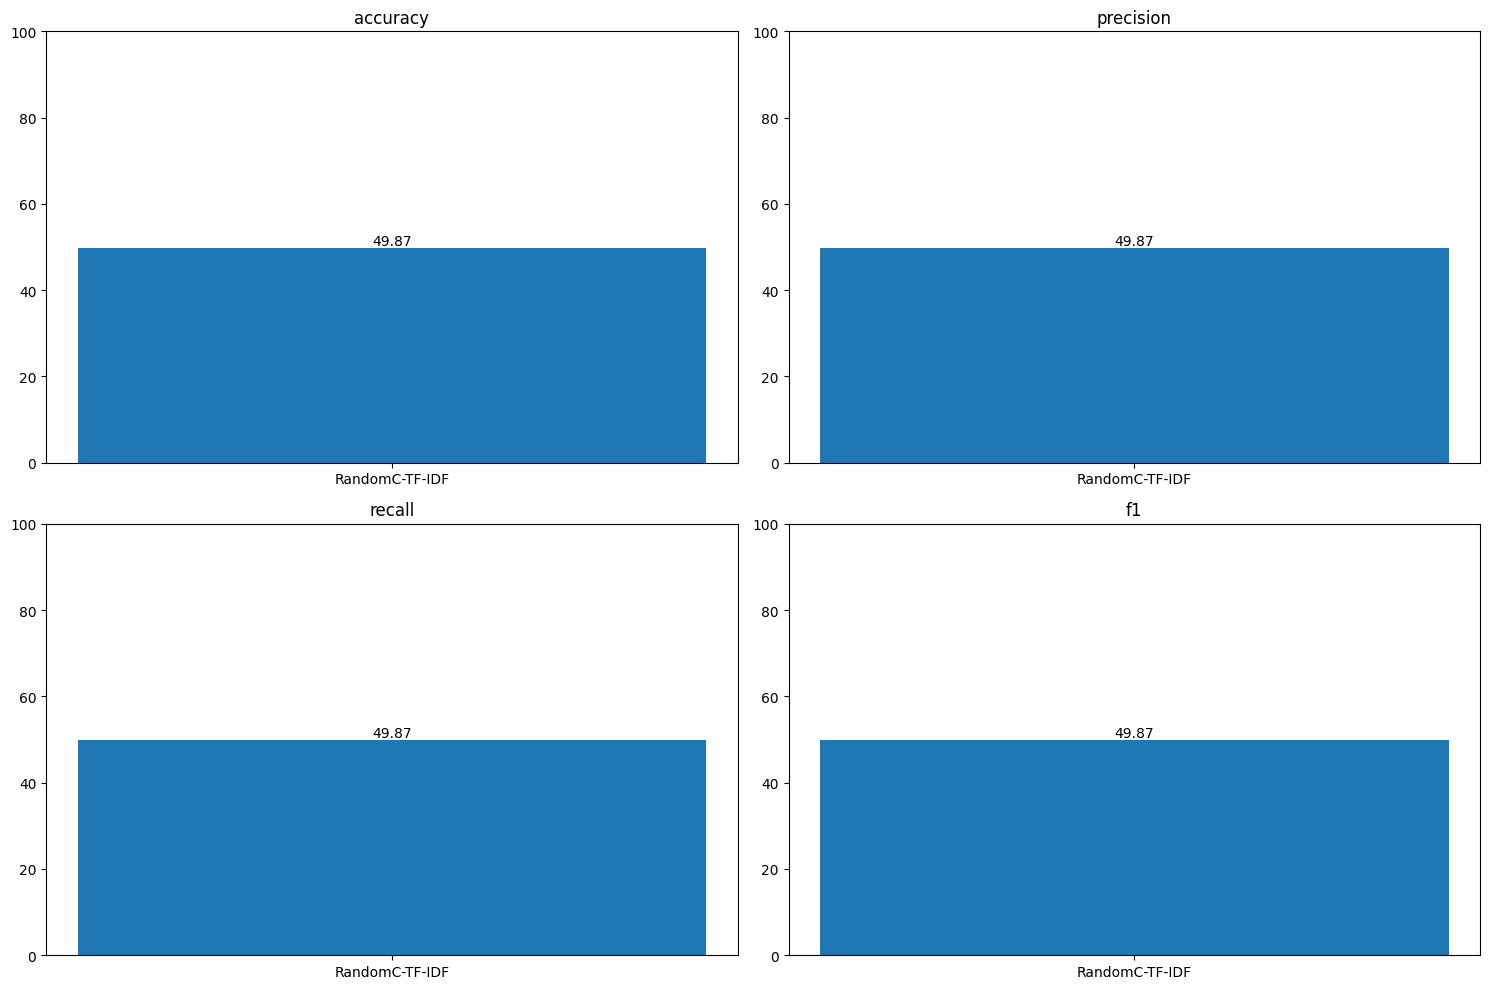

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier

pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the classifier to the training data
pipeline.fit(df_train['clean_text'])
##Creating matrix
tf_idf_matrix = pipeline.transform(df_train['clean_text'])
val_idf_matrix = pipeline.transform(df_test['clean_text']) #Changed validation for test
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_matrix.toarray(), columns=pipeline.named_steps['vect'].get_feature_names_out())
val_mtx = pd.DataFrame(data=val_idf_matrix.toarray(), columns=pipeline.named_steps['vect'].get_feature_names_out())

##Innitializing RandomClassifier
dummy_classifier = DummyClassifier(strategy='uniform')
# Fit the classifier to the training data
dummy_classifier.fit(tfidf_mtx, df_train['label'])

# Make predictions on the testing data
y_pred = dummy_classifier.predict(val_mtx)

# Calculate accuracy (or any other metric)
metrics_val= Metrics()
metrics_val.run(test_labels, y_pred, "RandomC-TF-IDF")
metrics_val.plot()


## Baseline Implementation

Baseline Implementation (0.5 points): Develop a rule-based classifier as a baseline. Discuss its performance in the context of the dataset's complexity and compare it with human-level performance if available.

### Rule-Based using Spacy Matcher

In [30]:
## Call positive words from Positive LDA
print(unique_pos)

{'school', 'need', 'weekend', 'friday', 'oh', 'going', 'watch', 'hey', 'sure', 'best', 'little', 'come', 'tonight', 'good', 'yay', 'today', 'could', 'nice', 'awesome', 'everyone', 'right', 'working', 'next', 'hi', 'would', 'follow', 'im', 'thanks', 'show', 'morning', 'video', 'keep', 'please', 'let', 'want', 'well', 'twitter', 'time', 'beautiful', 'watching', 'day', 'go', 'love', 'guy', 'game', 'movie', 'finally', 'really', 'amazing', 'made', 'fun', 'get', 'know', 'girl', 'also', 'life', 'one', 'got', 'haha', 'better', 'take', 'party', 'people', 'night', 'always', 'friend', 'getting', 'omg', 'great', 'think', 'new', 'lunch', 'looking', 'way', 'cool', 'still', 'live', 'happy', 'glad', 'like', 'see', 'tweet', 'ok', 'lol', 'sweet', 'thank', 'done', 'first', 'check', 'wait', 'look', 'yeah', 'luck', 'yes', 'music', 'song', 'back', 'birthday', 'say'}


In [31]:
## Get all the most relevant positive terms
positives = ['cute','aw','best','happy','haha',
             'amazing','fun','great','yay','love',
             'lol','excited','awesome','wow','nice','beautiful',
             'cool','glad','good']

print(positives)

['cute', 'aw', 'best', 'happy', 'haha', 'amazing', 'fun', 'great', 'yay', 'love', 'lol', 'excited', 'awesome', 'wow', 'nice', 'beautiful', 'cool', 'glad', 'good']


In [32]:
## Call negative words from Negative LDA
print(unique_neg)

{'need', 'oh', 'going', 'watch', 'much', 'damn', 'guess', 'wan', 'sad', 'tomorrow', 'someone', 'gone', 'tonight', 'head', 'ugh', 'find', 'today', 'could', 'right', 'working', 'rain', 'im', 'would', 'show', 'morning', 'already', 'please', 'week', 'let', 'sorry', 'want', 'well', 'missed', 'never', 'car', 'twitter', 'something', 'sick', 'time', 'watching', 'day', 'ever', 'go', 'mean', 'weather', 'wish', 'love', 'house', 'exam', 'missing', 'really', 'hurt', 'fun', 'bored', 'get', 'feeling', 'last', 'know', 'one', 'got', 'left', 'take', 'work', 'dont', 'people', 'night', 'bad', 'home', 'getting', 'omg', 'hope', 'think', 'new', 'hate', 'suck', 'away', 'still', 'make', 'lost', 'sleep', 'aw', 'hour', 'like', 'tired', 'lol', 'miss', 'trying', 'even', 'went', 'wait', 'look', 'yeah', 'phone', 'hard', 'thought', 'back', 'year', 'feel', 'say'}


In [33]:
## Get all the most relevant negative terms
negatives = ['sick','hurt','tired','hate','bad',
             'damn','never','miss','suck','sorry',
             'ugh','sad','lost', 'bored']

print(negatives)

['sick', 'hurt', 'tired', 'hate', 'bad', 'damn', 'never', 'miss', 'suck', 'sorry', 'ugh', 'sad', 'lost', 'bored']


### Implement rule-based conditions for our baseline model

In [34]:
import spacy
from spacy.matcher import Matcher

#loading and initializing nlp object
nlp = spacy.load('en_core_web_sm')
## Initializing Matcher
matcher = Matcher(nlp.vocab)

In [35]:
## Initializing Matcher
matcher = Matcher(nlp.vocab)

# based on word cloud
positive_patterns = [
    [{'LOWER': 'cute'}],
    [{'LOWER': 'aw'}],
    [{'LOWER': 'best'}],
    [{'LOWER': 'happy'}],
    [{'LOWER': 'haha'}],
    [{'LOWER': 'amazing'}],
    [{'LOWER': 'fun'}],
    [{'LOWER': 'great'}],
    [{'LOWER': 'yay'}],
    [{'LOWER': 'love'}],
    [{'LOWER': 'lol'}],
    [{'LOWER': 'excited'}],
    [{'LOWER': 'awesome'}],
    [{'LOWER': 'wow'}],
    [{'LOWER': 'nice'}],
    [{'LOWER': 'beautiful'}],
    [{'LOWER': 'cool'}],
    [{'LOWER': 'glad'}],
    [{'LOWER': 'good'}]
]


# based on word cloud
negative_patterns = [
    [{'LOWER': 'sick'}],
    [{'LOWER': 'hurt'}],
    [{'LOWER': 'tired'}],
    [{'LOWER': 'hate'}],
    [{'LOWER': 'bad'}],
    [{'LOWER': 'damn'}],
    [{'LOWER': 'never'}],
    [{'LOWER': 'miss'}],
    [{'LOWER': 'suck'}],
    [{'LOWER': 'sorry'}],
    [{'LOWER': 'ugh'}],
    [{'LOWER': 'sad'}],
    [{'LOWER': 'lost'}],
    [{'LOWER': 'bored'}]
]


## Adding patterns to matcher
matcher.add('positives',positive_patterns)
matcher.add('negatives',negative_patterns)


In [36]:
#Matching elements in documents
## Matching VALIDATION
docs_v = [nlp(doc) for doc in df_test['clean_text']]
matches_v = [matcher(d) for d in docs_v]

In [37]:
def matching_func(d,ms):
    #Return the index and the total number of matches per row
    rows_data = []
    for (i, match),doc in zip(enumerate(ms),d):
        #variables for defining current row/index
        row = 0
        row=i
        # positive variables
        positives = 0
        pos_w = []
        # negative variables
        negatives = 0
        neg_w = []

        diction = {'index':0,'total':0, 'positive':0 ,'negative':0,'pos_words':[],'neg_words':[]}
        # Filling dictionary
        diction['index'] = row
        diction['total'] = len(match)
        
        for match_id, start, end in match:
            if nlp.vocab.strings[match_id] == "positives":
                # store positive matched words
                pos_words = doc[start:end].text
                pos_w.append(pos_words)
                #diction['pos_words'] = pos_w
                # store number of positive words
                positives = len(pos_w)
                diction['positive'] = positives
            elif nlp.vocab.strings[match_id] == "negatives":
                # store negative matched words
                neg_words = doc[start:end].text
                neg_w.append(neg_words)
                #diction['neg_words'] = neg_w
                # store number of negative words
                negatives = len(neg_w)
                diction['negative'] = negatives
        
        #Add words matched to dictionary
        diction['pos_words'] = pos_w
        #diction['positive'] = positives
        diction['neg_words'] = neg_w
        #diction['negative'] = negatives

        diction = {k: np.nan if (not v and v != 0) else v for k, v in diction.items()}

        rows_data.append(diction)

    df = pd.DataFrame(rows_data)
    return df
        #print(diction['index'],' ',diction['total'],' ',diction['pos_words'],' ',diction['positive'],' ',diction['neg_words'],' ',diction['negative'])

In [38]:

va_df = matching_func(docs_v,matches_v)
va_df

,index,total,positive,negative,pos_words,neg_words
0,0,1,1,0,[happy],NaN
1,1,0,0,0,NaN,NaN
2,2,0,0,0,NaN,NaN
3,3,2,0,2,NaN,"[bored, sad]"
4,4,1,1,0,[good],NaN
...,...,...,...,...,...,...
18594,18594,0,0,0,NaN,NaN
18595,18595,1,0,1,NaN,[bad]
18596,18596,2,0,2,NaN,"[never, never]"
18597,18597,0,0,0,NaN,NaN


In [39]:
# Create a new column 'proba' where 1 is returned if positives are greater than negatives, else 0
threshold = 0.5

va_df['proba'] = np.where(va_df['total'] != 0, (va_df['positive'] / va_df['total']) > threshold, 0)
va_df

,index,total,positive,negative,pos_words,neg_words,proba
0,0,1,1,0,[happy],NaN,1
1,1,0,0,0,NaN,NaN,0
2,2,0,0,0,NaN,NaN,0
3,3,2,0,2,NaN,"[bored, sad]",0
4,4,1,1,0,[good],NaN,1
...,...,...,...,...,...,...,...
18594,18594,0,0,0,NaN,NaN,0
18595,18595,1,0,1,NaN,[bad],0
18596,18596,2,0,2,NaN,"[never, never]",0
18597,18597,0,0,0,NaN,NaN,0


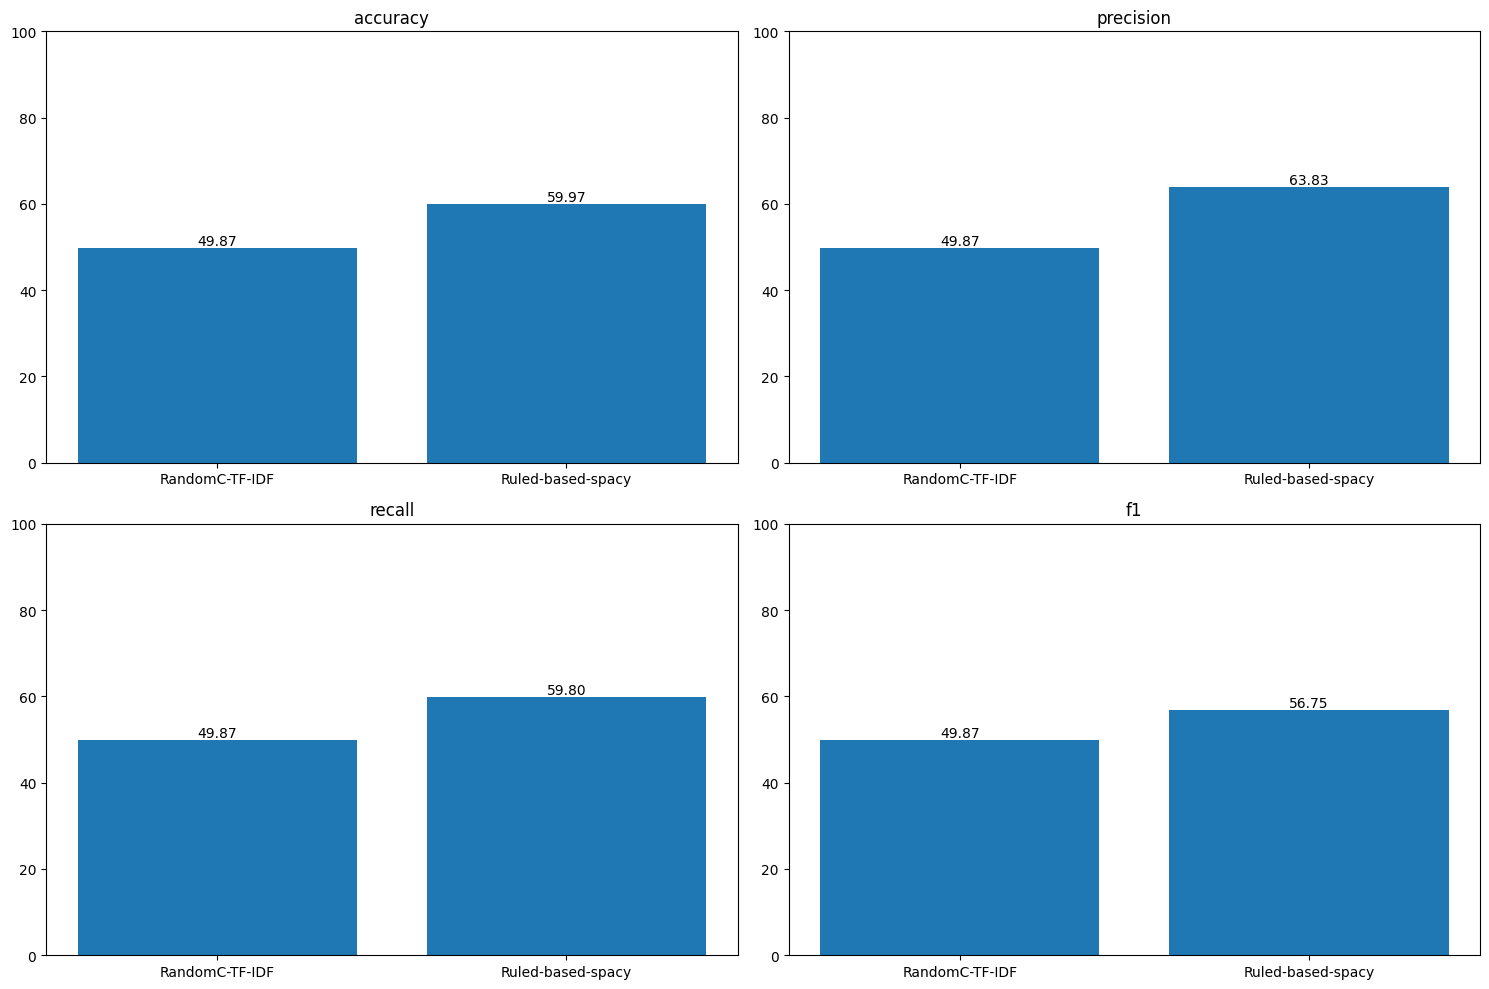

In [40]:
## Comparing with real 

metrics_val.run(test_labels, va_df['proba'], "Ruled-based-spacy")
metrics_val.plot()

### Error Analysis

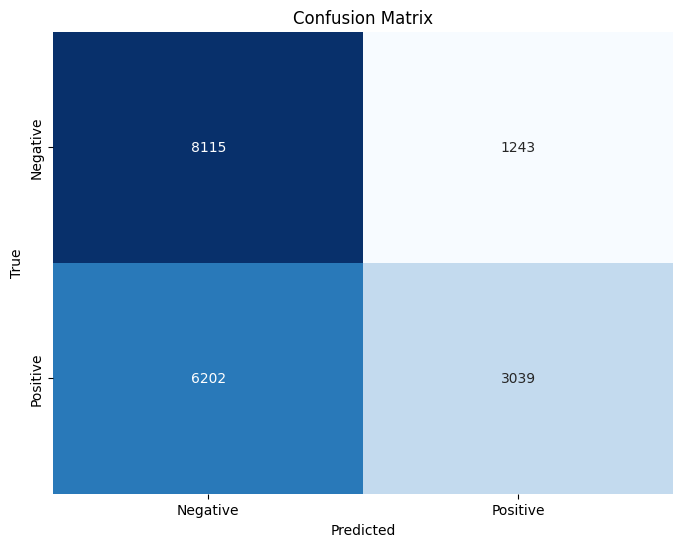

In [41]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(test_labels, va_df['proba'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [42]:
df_val2 = df_test.copy()

#Create an index column to join with our prediction results
df_val2 = df_val2.reset_index()

## Merge with new data
merged_data = df_val2.merge(va_df[['index','proba']],how='left',left_on='index',right_on='index',suffixes=['_tr','_df'])
merged_data.head()

,index,text,label,text_length,clean_text,clean_emotions,hashtag,text_emotion,proba
0,0,is happy that Fischerspooner is going to play ...,1,17,is happy that fischerspooner is going to play ...,,,is happy that fischerspooner is going to play ...,1
1,1,Can't decide if I'm hot or cold So I'm wearin...,0,21,can not decide if i am hot or cold so i am wea...,,,can not decide if i am hot or cold so i am wea...,0
2,2,@muzik_man i didnt fall asleep last night..i g...,0,15,i didnt fall asleep last night . i got a boote...,,,i didnt fall asleep last night . i got a boote...,0
3,3,"so bored, found out, i can't touch my nose wit...",0,15,"so bored , found out , i can not touch my nose...",,,"so bored , found out , i can not touch my nose...",0
4,4,Good morntings!,1,2,good morntings !,,,good morntings !,1


In [43]:
## Printing False Negatives
print('MISSCLASSIFIED TWEETS EXPLORATION')
for i in merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['clean_text'][0:25]:
    print(i)

MISSCLASSIFIED TWEETS EXPLORATION
is sick eh i hate it ! lucky day off tomorrow
you were reaally handsome in the oc , i lovee that serie , too bad it had finish , keep doing like thiss
do not know if ed greene will use them , but i emailed your video to him .
just got a volunteer application for the local spca
want to hear " sing " but can not find it ! i have tried myspace with no luck ! point me in the right direction doll
most deffz a classic , i got it now , soo yummy
gosh , i hope you are not late for work .
woot so does that mean your bringing peach pie and bewbs when you come see us
congrats on finishing
sorry i missed ur call . i was at soccer . we won - yay . i played alright . anth came to watch me play
hehe , i still dont understand the game . but i sure will do so
out and about ! some much to do so little time !
had a gr8 time at the uni tav 2 day with the girls chillaxin at home now b4 gettin down to business !
i will not be sad i know how this things are important ya
if a

#### How can we reduce the amount of false negatives?

Twitter data presents certain challenges:

- Frequently, we encounter questions that lack clear sentiment expression.
- Sometimes, the count of positive and negative instances is equal, leading to classification as negatives based on our threshold.
- Given the intricate variety of positive patterns, we won't be able to cover all possibilities, therefore increasing the number of false negatives.
- Positive and negative sarcasm further complicates accurate classification, as seen in examples like: "I live in a basement. That's why I am so mysterious."


Proposal to reduce False negatives  

To address the issue of false negatives, we suggest a strategy suited to the complexity of tweets, characterized by informal language. Our plan involves conducting regular error analyses and augmenting our matcher patterns with new positive patterns. This iterative approach aims to develop a robust classifier capable of capturing all positive patterns accurately over time. However, we must also devise methods to handle neutral tweets and positive/negative sarcasm.

- Our initial step entails identifying missing positive patterns within misclassified tweets and incorporating them into our matcher.





238


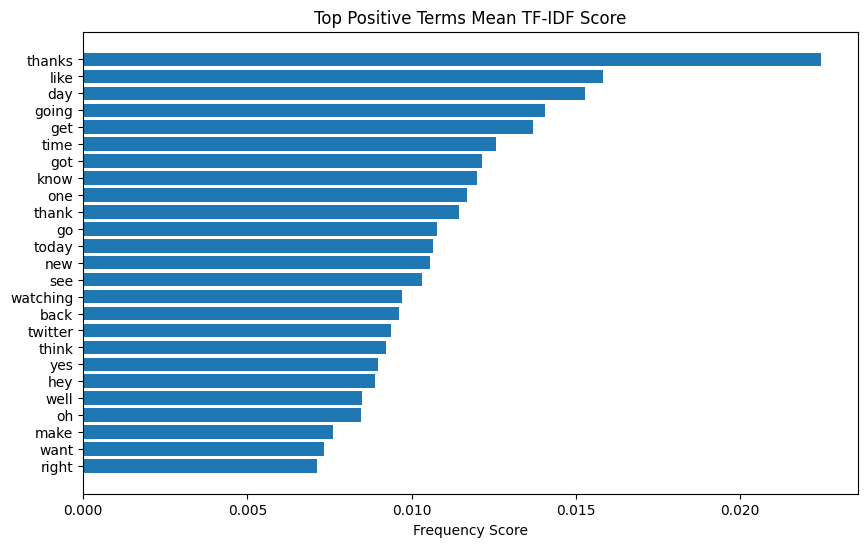

In [44]:
## Plot TFIDF identify missing positive patterns
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)],1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

In [45]:
#Identifying positive patterns:

positives2 = ['thanks','new','like','thank','well']

print(positives2)

['thanks', 'new', 'like', 'thank', 'well']


In [46]:
## Adding new patterns to matcher
# based on word cloud
positive_patterns2 = [
    [{'LOWER': 'thanks'}],
    [{'LOWER': 'new'}],
    [{'LOWER': 'like'}],
    [{'LOWER': 'thank'}],
    [{'LOWER': 'well'}]
]

## Adding patterns to matcher
matcher.add('positives',positive_patterns2)

In [47]:
#Matching elements in documents
## Matching VALIDATION
docs_v2 = [nlp(doc) for doc in merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['clean_text']]
matches_v2 = [matcher(d) for d in docs_v2]

In [48]:
va_df2 = matching_func(docs_v2,matches_v2)
va_df2

,index,total,positive,negative,pos_words,neg_words
0,0,2,0,2,NaN,"[sick, hate]"
1,1,2,1,1,[like],[bad]
2,2,0,0,0,NaN,NaN
3,3,0,0,0,NaN,NaN
4,4,0,0,0,NaN,NaN
...,...,...,...,...,...,...
6197,6197,0,0,0,NaN,NaN
6198,6198,0,0,0,NaN,NaN
6199,6199,0,0,0,NaN,NaN
6200,6200,1,0,1,NaN,[bad]


In [49]:
va_df2['proba'] = np.where(va_df2['total'] != 0, (va_df2['positive'] / va_df2['total']) > threshold, 0)
va_df2

,index,total,positive,negative,pos_words,neg_words,proba
0,0,2,0,2,NaN,"[sick, hate]",0
1,1,2,1,1,[like],[bad],0
2,2,0,0,0,NaN,NaN,0
3,3,0,0,0,NaN,NaN,0
4,4,0,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...
6197,6197,0,0,0,NaN,NaN,0
6198,6198,0,0,0,NaN,NaN,0
6199,6199,0,0,0,NaN,NaN,0
6200,6200,1,0,1,NaN,[bad],0


In [50]:
## Checking That lens for both results match
print(len(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']) == len(va_df2['proba']))
print(len(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']))
print(len(va_df2['proba']))


True
6202
6202


In [51]:
#check if missing values
print(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba'].isna().mean())
print(va_df2['proba'].isna().mean())


0.0
0.0


In [52]:
# Different indexes
print(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)].index)
print(va_df2.index)

Index([   11,    12,    18,    20,    23,    25,    27,    28,    30,    35,
       ...
       18572, 18573, 18582, 18583, 18584, 18589, 18591, 18594, 18595, 18597],
      dtype='int64', length=6202)
RangeIndex(start=0, stop=6202, step=1)


In [53]:
# Make copies of the dataframes
merged_data_copy = merged_data.copy()
va_df2_copy = va_df2.copy()

# Find the subset indices in the copied dataframe


df_merge = pd.DataFrame({'index':merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)].index,
                         'proba1':(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']).tolist(),
                         'proba2':va_df2['proba'].tolist()
                         })

df_merge['proba3'] = np.where(df_merge['proba1'] != df_merge['proba2'], df_merge['proba2'], df_merge['proba1'])
df_merge.set_index('index', inplace=True)
df_merge


,proba1,proba2,proba3
index,,,
11,0,0,0
12,0,0,0
18,0,0,0
20,0,0,0
23,0,0,0
...,...,...,...
18589,0,0,0
18591,0,0,0
18594,0,0,0


In [54]:
#Now that we made sure that indexes will match, replace in merged data:
for index, value in zip(merged_data_copy[(merged_data_copy['label'] == 1) & (merged_data_copy['proba'] == 0)].index, df_merge['proba3']):
    merged_data_copy.loc[index, 'proba'] = value

---

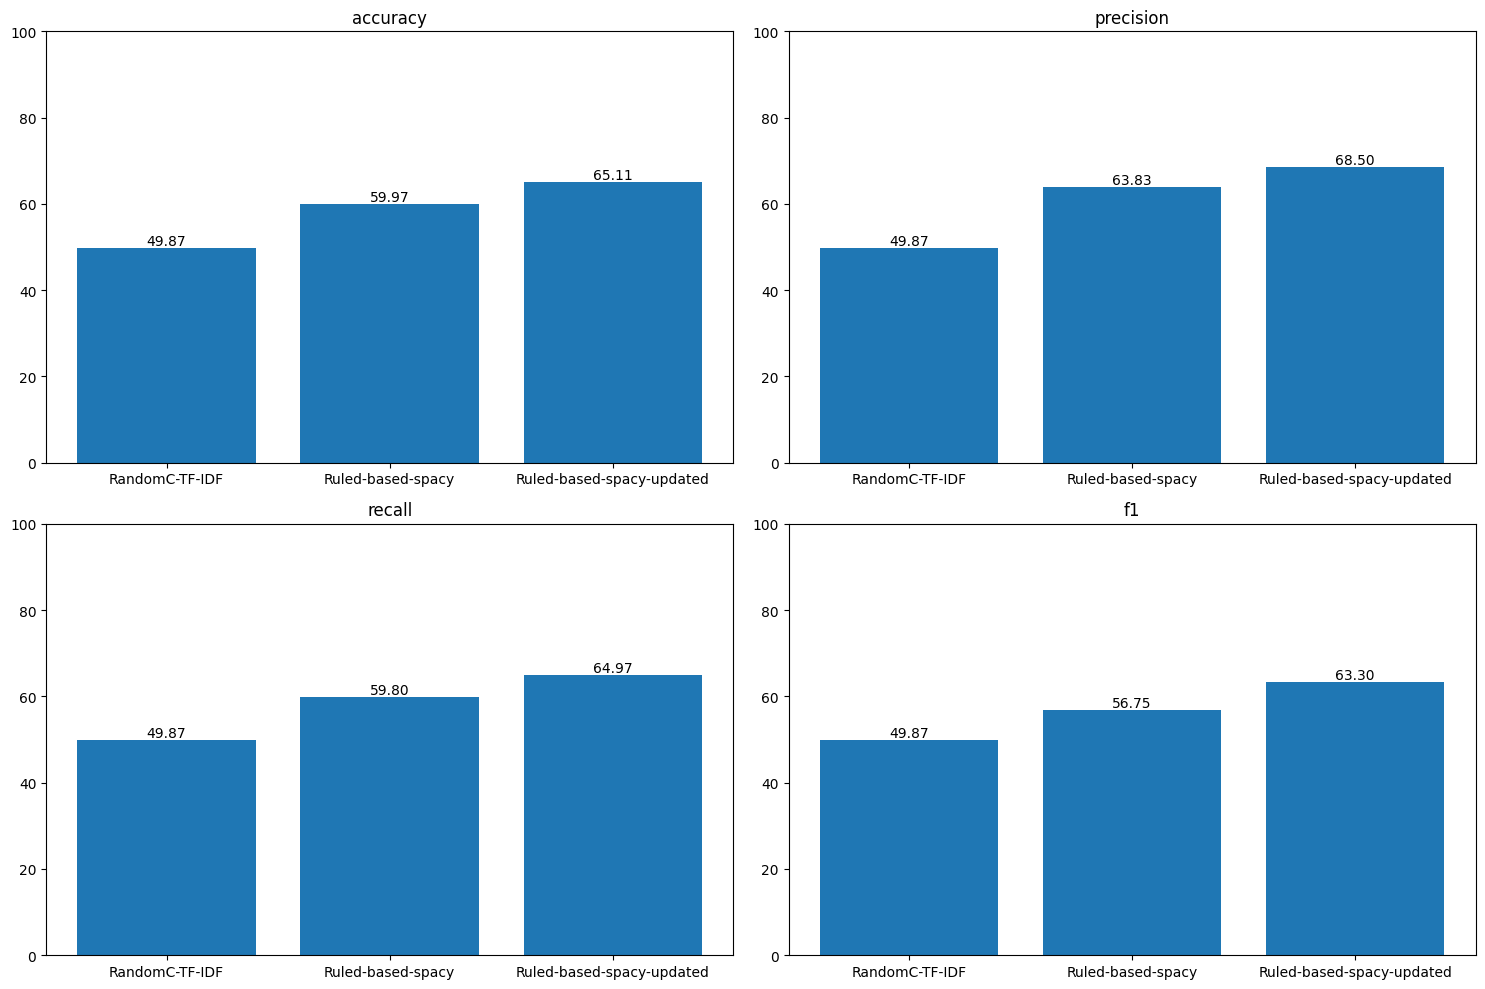

In [55]:
metrics_val.run(test_labels, merged_data_copy['proba'], "Ruled-based-spacy-updated")
metrics_val.plot()

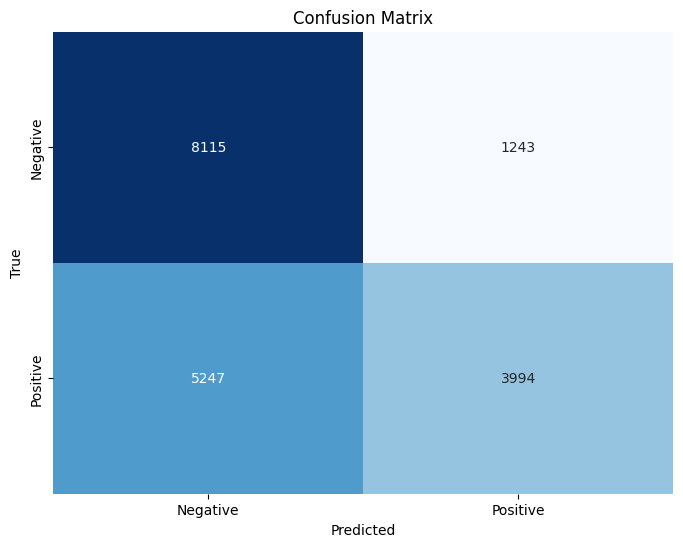

In [56]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels,  merged_data_copy['proba'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [57]:
## Reduction of False Negatives
((17495 / 20656) -1) * 100

-15.303059643687067

#### We managed to reduce the number of false negatives by 15% after incorporating the new batch of positive patterns learned from the error analysis

### Rule-Based Benchmark with Vader

In [58]:
# Initialize the SentimentIntensityAnalyzer.
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

# Apply lambda function to get compound scores.
function = lambda title: vader.polarity_scores(title)['compound']

# Calculate compound score and get tweet length
df_test['sentiment'] = df_test['clean_text'].apply(function)
df_test['clean_length'] = [len(i.split()) for i in df_test['clean_text']]

test = df_test[['clean_text','clean_length','sentiment']]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mikelgallo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [59]:
#Adding Sentiment Label
def getAnalysis(score):
 if score < 0:
    return 'Negative'
 elif score == 0:
    return 'Neutral'
 else:
    return 'Positive'

df_test['sentiment_label'] = df_test['sentiment'].apply(getAnalysis)

#Scaling score to the length of the review
df_test.head(5)

,text,label,text_length,clean_text,clean_emotions,hashtag,text_emotion,sentiment,clean_length,sentiment_label
0,is happy that Fischerspooner is going to play ...,1,17,is happy that fischerspooner is going to play ...,,,is happy that fischerspooner is going to play ...,0.8353,19,Positive
1,Can't decide if I'm hot or cold So I'm wearin...,0,21,can not decide if i am hot or cold so i am wea...,,,can not decide if i am hot or cold so i am wea...,0.2023,26,Positive
2,@muzik_man i didnt fall asleep last night..i g...,0,15,i didnt fall asleep last night . i got a boote...,,,i didnt fall asleep last night . i got a boote...,0.0000,16,Neutral
3,"so bored, found out, i can't touch my nose wit...",0,15,"so bored , found out , i can not touch my nose...",,,"so bored , found out , i can not touch my nose...",-0.2228,19,Negative
4,Good morntings!,1,2,good morntings !,,,good morntings !,0.4926,3,Positive


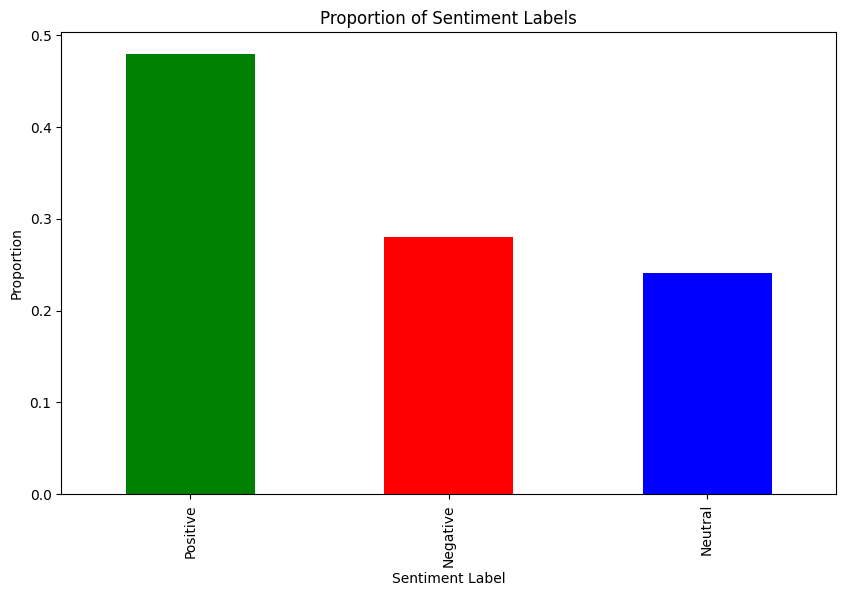

In [60]:
import matplotlib.pyplot as plt

# Get counts of each category in 'sentiment_label'
sentiment_counts = df_test['sentiment_label'].value_counts()

# Calculate proportion of each category
total_samples = len(df_test)
sentiment_proportions = sentiment_counts / total_samples

# Define colors for each sentiment
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

# Plot bar chart with colors
sentiment_proportions.plot(kind='bar', figsize=(10, 6), color=[colors[label] for label in sentiment_proportions.index])

# Set labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Proportion')
plt.title('Proportion of Sentiment Labels')

# Show plot
plt.show()


## Looking at WordCloud for inspection of Neutral Words

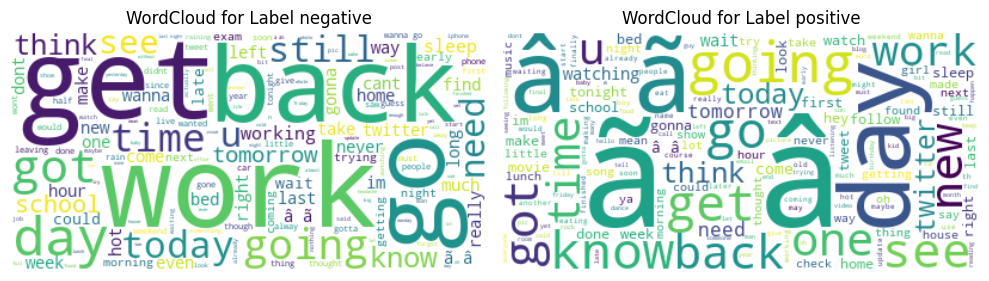

In [61]:
## Looking at a WordCloud to inspect the words in neutral

labels = {0: 'negative', 1: 'positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(df_test[df_test['sentiment_label']=='Neutral']['clean_text'], df_test[df_test['sentiment_label']=='Neutral']['label']):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

### Classifying Neutral tweets

In [62]:
#Clasifying neutral 
# Iterate over rows of DataFrame where 'sentiment_label' is 'Neutral'
for index, row in df_test[df_test['sentiment_label'] == 'Neutral'].iterrows():
    # Analyze sentiment of the text
    score = vader.polarity_scores(row['clean_text'])
    if score['compound'] == 0:  # Positive sentiment
        df_test.at[index, 'sentiment_label'] = 'Negative' ##Any tweet that has no good emotion will be treated as negative
    else:  # Neutral sentiment
        df_test.at[index, 'sentiment_label'] = 'Positive'


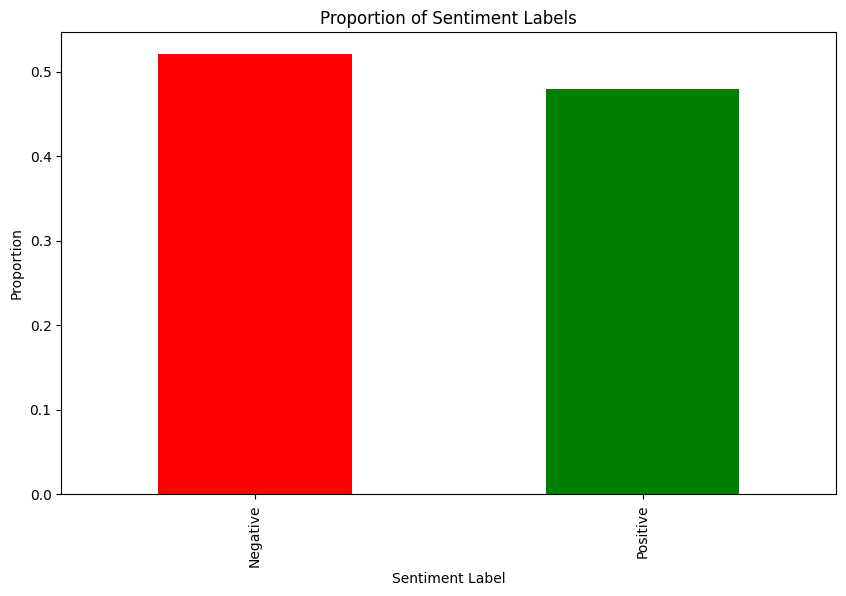

In [63]:
# Get counts of each category in 'sentiment_label'
sentiment_counts = df_test['sentiment_label'].value_counts()

# Calculate proportion of each category
total_samples = len(df_test)
sentiment_proportions = sentiment_counts / total_samples

# Define colors for each sentiment
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

# Plot bar chart with colors
sentiment_proportions.plot(kind='bar', figsize=(10, 6), color=[colors[label] for label in sentiment_proportions.index])

# Set labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Proportion')
plt.title('Proportion of Sentiment Labels')

# Show plot
plt.show()

### Rule-Based Model Performance

In [64]:
#Convert to binary
df_test['sentiment_label'] = [1 if x == 'Positive' else 0 for x in df_test['sentiment_label']]
y_pred = df_test['sentiment_label']
original_labels = df_test['label']

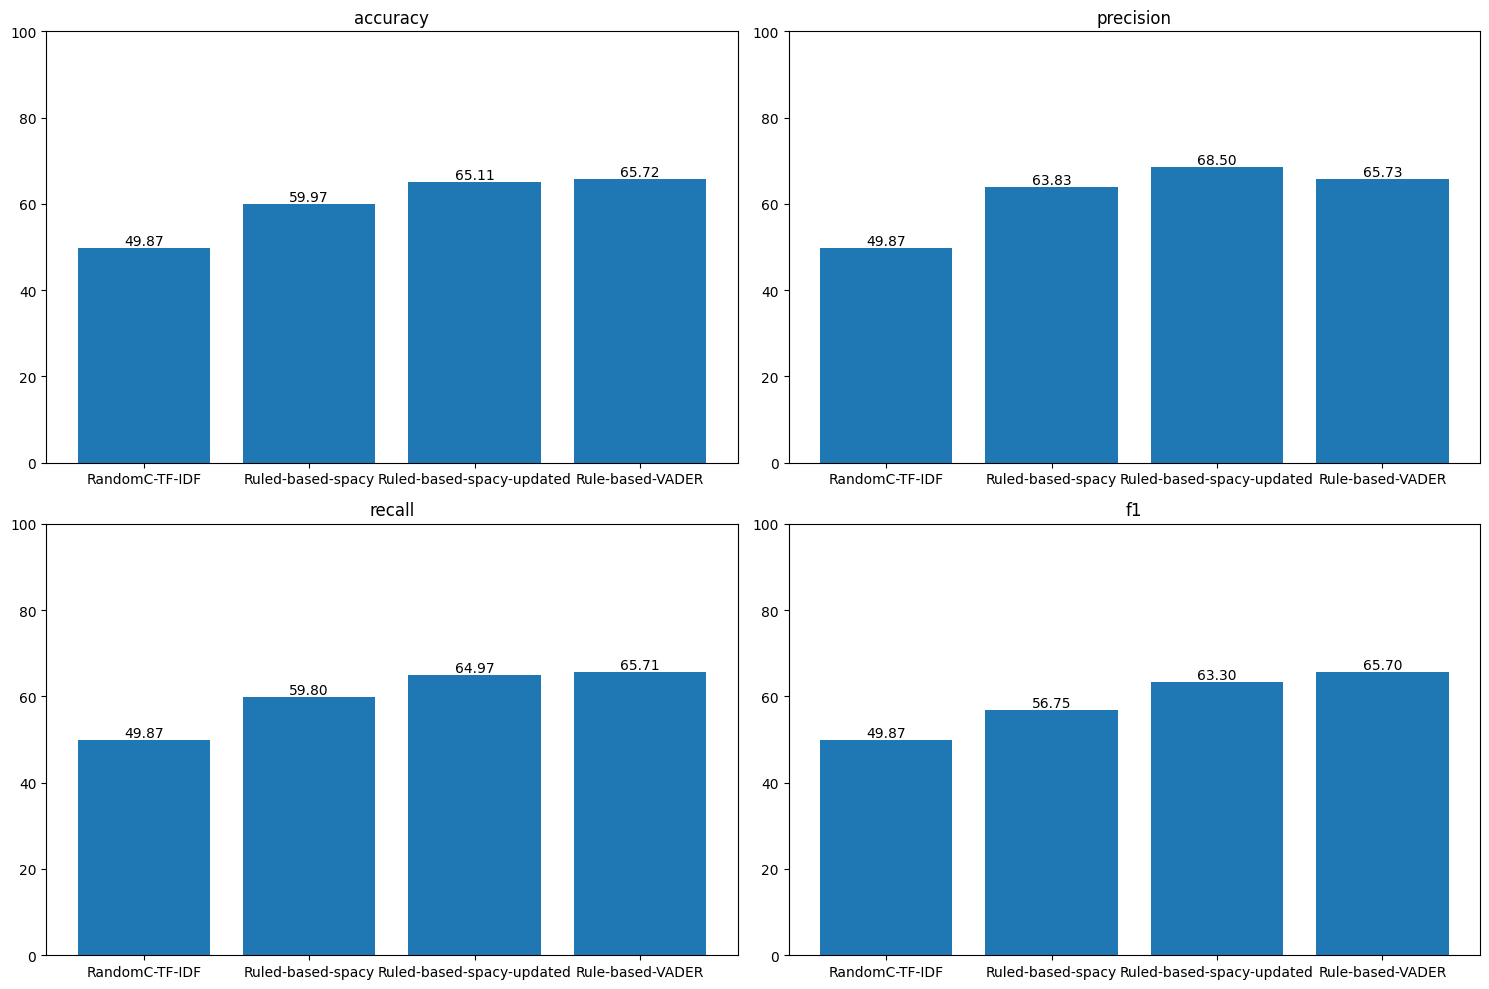

In [65]:
## Model Performance

metrics_val.run(original_labels, y_pred, "Rule-based-VADER")
metrics_val.plot()

---

# BERT Model with Limited Data (0.5 points)

#### Train a BERT-based model using only 32 labeled examples and assess its performance.

In the following exercises we will work with clean text.

In [66]:
# imports for Part II
#! pip install transformers==4.37.2
import transformers
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from transformers import TFDistilBertModel
from keras.utils import custom_object_scope
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix
import random
from sklearn.metrics import confusion_matrix
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy
sp = spacy.load('en_core_web_sm')
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mikelgallo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mikelgallo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [67]:
train_data_clean = df_train['clean_text']
validation_data_clean = df_val['clean_text']
test_data_clean = df_test['clean_text']

In [68]:
# Set the seed for reproducibility
np.random.seed(42)

# First, we'll select 32 random rows from the DataFrame using the sample method.
df_train_32 = df_train.sample(n=32)

In [69]:
train_data_32 = df_train_32['clean_text']
train_labels_32 = df_train_32['label']

### BERT SETUP

In [71]:
checkpoint="cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=32 # impossible to have bigger batch as far as we have just 32 observations in the train
max_length=40 # fine for the length of the sentences in our dataset - changed it according to the distribution
rate = 0.5 # dropout parameters - tried different options, 0.5 still performs better
num_labels = len(np.unique(validation_labels))

AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
# ## Input
# input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
# input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# # Embedding layers
# embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# # we need only the first token representation nothing else from the last layer
# final_embedding_layer = embedding_layer[0] #last layer of BERT
# # Extract only the [CLS] token's embeddings
# cls_token_embeddings = final_embedding_layer[:, 0, :]
# # First dimension is the number of rows
# # Second dimension is the number of tokens (in our case 64)
# # The last dimension is the embedding size, in this case 768

# # Let's add some dropout to reduce overfitting
# output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# # One dense layer to process the last layer
# output = tf.keras.layers.Dense(num_labels,
#                                kernel_initializer="glorot_uniform",
#                                activation='softmax')(output_layer)


# bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

# bert_model.summary()

In [ ]:
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras import regularizers

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# we need only the first token representation nothing else from the last layer
final_embedding_layer = embedding_layer[0] #last layer of BERT
# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]
# First dimension is the number of rows
# Second dimension is the number of tokens (in our case 64)
# The last dimension is the embedding size, in this case 768

# Let's add some dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer with L2 regularization
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax',
                               kernel_regularizer=regularizers.l2(0.01))(output_layer)

bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=output)

bert_model.summary()

In [ ]:
def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_labels_32).reshape(-1, 1)).toarray()

In [ ]:
# Define a custom generator function that yields batches and updates the tqdm progress bar
def tqdm_generator(generator, steps_per_epoch):
    for batch in tqdm(generator, total=steps_per_epoch, desc="Epoch"):
        yield batch

X_train = np.array(train_data_32)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=7, steps_per_epoch=steps_per_epoch)


In [ ]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)


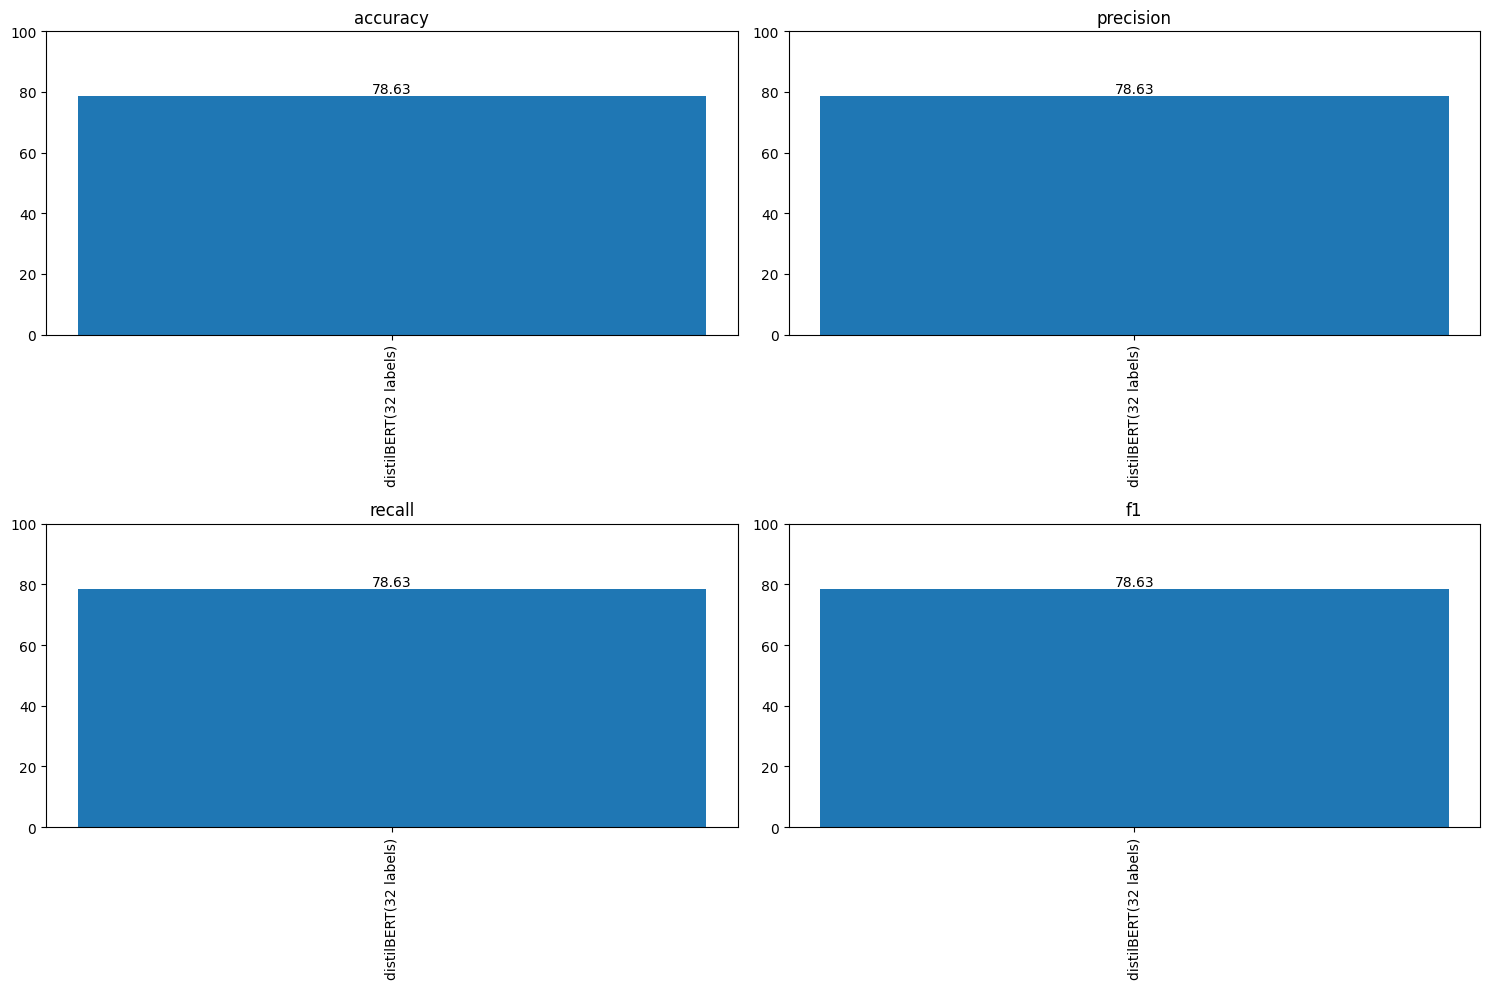

In [ ]:
# get the final metrics
metrics_val= Metrics()
metrics_val.run(test_labels, valid_preds, "distilBERT(32 labels)")
metrics_val.plot()

As we see, BERT trained on 32 labels performs slightly better than random. Note that metrics vary in the range [0.52, 0.62], depending on the run, as all batches are randomly assigned.

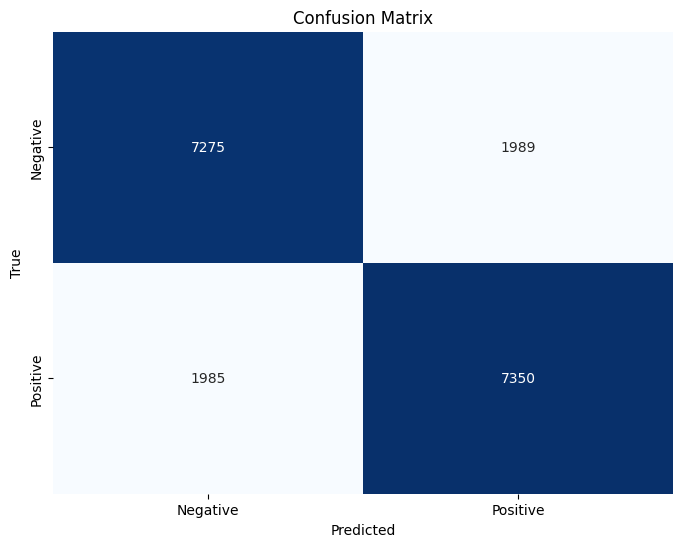

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, valid_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Dataset Augmentation (1 point)

#### Experiment with an automated technique to increase your dataset size without using LLMs. Evaluate the impact on model performance.

In [ ]:
# This function should be moved to the top of the notebook (Mikel used it in the first exercise)
# Function for data preprocessing

#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

#additional functions

def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos

def tokenize(text, modulation):
    if modulation<2:
        tokens = re.split(r'\W+', text)
        stems = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            lowers=abbr_or_lower(token)
            if lowers not in stop_words:
                if re.search('[a-zA-Z]', lowers):
                    if modulation==0:
                        stems.append(lowers)
                    if modulation==1:
                        stems.append(porter.stem(lowers))
    else:
        sp_text=sp(text)
        stems = []
        lemmatized_text=[]
        for word in sp_text:
            lemmatized_text.append(word.lemma_)
        stems = [abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)]
    return " ".join(stems)


def vectorize(tokens, vocab):
    vector=[]
    for w in vocab:
        vector.append(tokens.count(w))
    return vector

### LDA
I performed some exploratory analysis (aka LDA), but as far as data is very small and randomly chosen to find any patterns is almost imposible and actually is not needed. Probably will just drop this part.

In [ ]:
# df_train_32['clean_text_tok'] = [tokenize(text, 2) for text in df_train_32['clean_text']]

In [ ]:
# cv = CountVectorizer(ngram_range = (1,2), lowercase=True, stop_words='english')

# cv.fit(df_train_32['clean_text_tok'])

# vectorized_text=cv.transform(df_train_32['clean_text_tok'])
# vectorized_text=vectorized_text.toarray()
# print("document term matrix has size", vectorized_text.shape)

In [ ]:
# dtm_sparse = csr_matrix(vectorized_text)

# # Convert sparse matrix to gensim corpus
# corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# # Create gensim dictionary from sklearn CountVectorizer vocabulary
# vocabulary_gensim = {}
# for key, val in cv.vocabulary_.items():
#     vocabulary_gensim[val] = key

# dictionary = corpora.Dictionary()
# dictionary.id2token = vocabulary_gensim
# dictionary.token2id = cv.vocabulary_

In [ ]:
# # Number of topics
# num_topics = 5

# # Custom alpha value
# alpha = [0.1] * num_topics

# # Build LDA model
# lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42, alpha=alpha)

# # Display the topics
# topics = lda_model.print_topics(num_words=30)
# print("Custom Alpha and Eta:")
# for topic in topics:
#     print(topic)


Text data augmentation approaches include:

+ Synonym Replacement: Replace words with their synonyms.
+ Random Insertion: Insert random words into the text.
+ Random Deletion: Randomly delete words from the text.
+ Random Swap: Swap two words randomly in the text.
+ Text Masking: Replace words or phrases with a mask token.

As far as we have very small dataset (DTM is of shape 32:305) I chose not to work with deletion or masking, but rather with synonyms. I thought of two approaches to do so:

### Data Augmentation: Manually Gathered Synonyms

First approach was to analyse the most common words associated with positive and negative sentiments and manually create a dictionary with synonyms. Then, I augmented data with 50 (tried more, but performance was worse, probably bacause of the limited variety of the changes and the fact, that probably misclassified observations could be misclassified now twice) observations and trained the same BERT with augmented data.

In [ ]:
# I had slightly different approach, but changed it to Mikel's so to have the same logic throughout the notebook. Will have to move this and next cell to the first exercise later on.
## Preprocessing texts
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the pipeline on the training data
pipeline.fit(df_train_32['clean_text'])

Pipeline(steps=[('prepro', TextPreprocessor()),
                ('vect',
                 CountVectorizer(max_df=0.97, min_df=0.005,
                                 ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(norm='l1'))])

In [ ]:
def tfidf_term(pipeline,df,sentiment):
# Access the CountVectorizer step from the pipeline
    count_vectorizer = pipeline.named_steps['vect']
    # Fit and transform the data
    tf_idf_pos_matrix = pipeline.transform(df[df['label']==sentiment]['clean_text'])
    # Convert count matrix to DataFrame
    vec_fr_mtx = pd.DataFrame(data=tf_idf_pos_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

    #Creating a dictionary of frequencies for our terms
    feature_names = count_vectorizer.get_feature_names_out()
    # Calculate Term frequency dictionary
    term_tfidf = np.mean(vec_fr_mtx, axis=0)
    #Store in a dictionary
    tfidf_dict = {i: n for i, n in zip(feature_names, term_tfidf)}
    print(len(term_tfidf))
    return feature_names, term_tfidf, tfidf_dict


def transform_to_dataframe(feature_names, score):
    # Create DataFrame with feature names and mean TF-IDF scores
    df = pd.DataFrame({'terms': feature_names, 'score': score})
    # Reset index
    df.reset_index(drop=True, inplace=True)
    return df


# Example usage:
def plot_freq_top(df,top,pos):
    df = df.sort_values(by='score',ascending = False)
    df = df.head(top)
    #We are going to set the

    # Plot the top N terms and their TF-IDF scores
    plt.figure(figsize=(10, 6))
    plt.barh(df['terms'], df['score'], align='center')
    plt.yticks(df['terms'])
    plt.xlabel('Frequency Score')
    plt.title(pos.format(top))
    #plt.xlim(0,0.010)
    plt.gca().invert_yaxis()  # Invert y-axis to display top terms at the top
    plt.show()

322


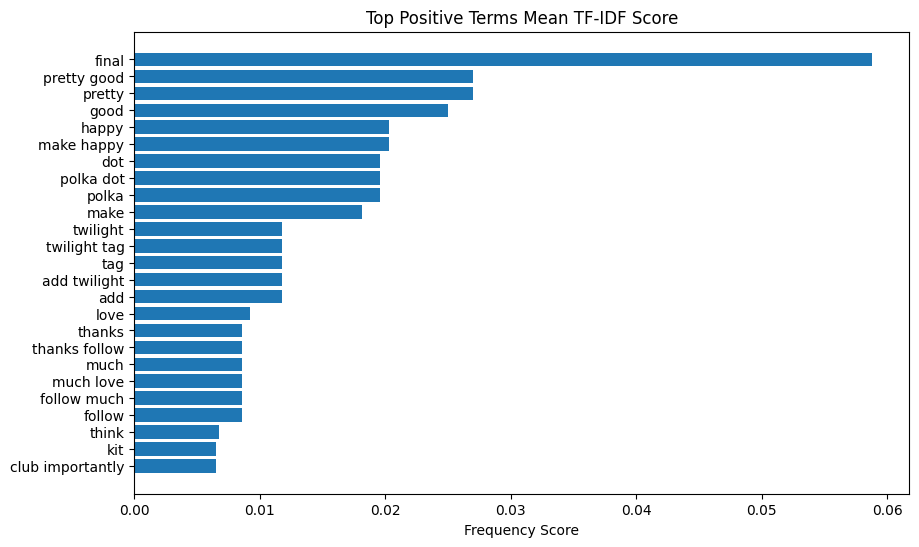

In [ ]:
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train_32,1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

322


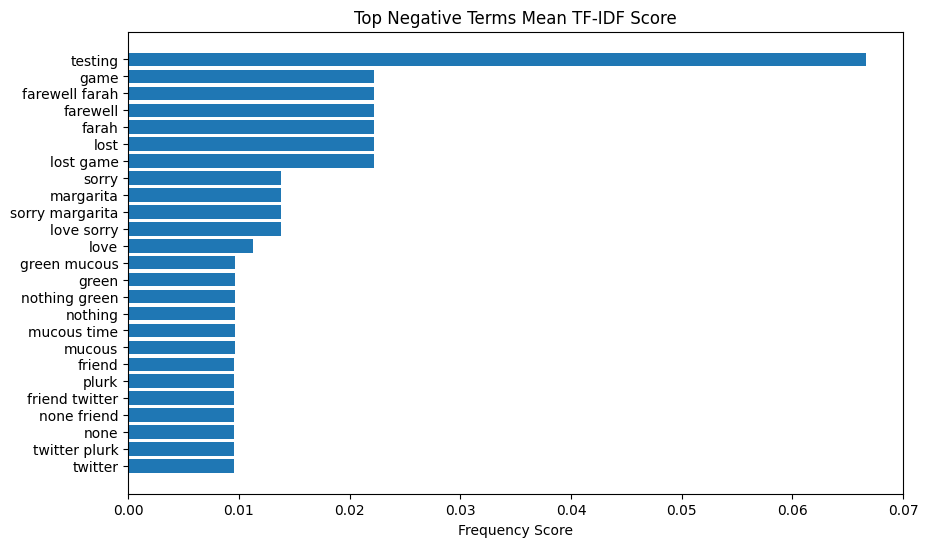

In [ ]:
neg = f'Top Negative Terms Mean TF-IDF Score'
## Posive Terms
neg_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train_32,0)
neg_tf_idf = transform_to_dataframe(neg_feature_names,term_tfidf)
plot_freq_top(neg_tf_idf,25,neg)

I got top 'most positive' and 'most negative' terms, manually chose some of them and assigned synonyms.

In [ ]:
# Sort the dataframe by the 'score' column in decreasing order
neg_tf_idf_sorted = neg_tf_idf.sort_values(by='score', ascending=False)
pos_tf_idf_sorted = pos_tf_idf.sort_values(by='score', ascending=False)

# Extract the top 25 terms from the sorted dataframe
top_terms_neg = neg_tf_idf_sorted['terms'].head(25).tolist()
top_terms_pos = pos_tf_idf_sorted['terms'].head(25).tolist()

# Print the list of top 25 terms
print(top_terms_neg)
print(top_terms_pos)

['testing', 'game', 'farewell farah', 'farewell', 'farah', 'lost', 'lost game', 'sorry', 'margarita', 'sorry margarita', 'love sorry', 'love', 'green mucous', 'green', 'nothing green', 'nothing', 'mucous time', 'mucous', 'friend', 'plurk', 'friend twitter', 'none friend', 'none', 'twitter plurk', 'twitter']
['final', 'pretty good', 'pretty', 'good', 'happy', 'make happy', 'dot', 'polka dot', 'polka', 'make', 'twilight', 'twilight tag', 'tag', 'add twilight', 'add', 'love', 'thanks', 'thanks follow', 'much', 'much love', 'follow much', 'follow', 'think', 'kit', 'club importantly']


In [ ]:
synonyms = {
    'school': ['education', 'academy'],
    'complicated': ['complex', 'difficult'],
    'bad': ['poor', 'negative', 'awful', 'lousy', 'rough'],
    'love': ['affection', 'adore', 'care for', 'like'],
    'guilty': ['regret', 'remorse'],
    'feel': ['emotion', 'vibe'],
    'oh': ['ah', 'ahh', 'oops'],
    'miss': ['long for', 'crave', 'feel loss'],
    'going': ['departing', 'leaving', 'traveling'],
    'dear': ['beloved', 'darling', 'precious'],
    'busy': ['occupied', 'engaged'],
    'working': ['laboring', 'employed'],
    'time': ['period', 'duration', 'interval'],
    'would': ['could', 'might', 'will'],
    'look': ['gaze', 'observe', 'glance'],
    'bed time': ['sleep time', 'rest time', 'night time'],
    'song': ['music', 'melody', 'tune'],
    'hi': ['hello', 'hey', 'greetings'],
    'love song': ['romantic music', 'passionate tune'],
    'want': ['desire', 'wish for', 'crave'],
    'please': ['kindly', 'if you please'],
}

In [ ]:
# Function to replace key word with a random synonym
def replace_with_synonym(text, synonyms_dict):
    words = text.split()
    for i, word in enumerate(words):
        if word in synonyms_dict:
            synonyms = synonyms_dict[word]
            # Randomly select a synonym
            new_word = random.choice(synonyms)
            # Replace the key word with the selected synonym
            words[i] = new_word
    return ' '.join(words)

# Initialize an empty DataFrame to store new observations
new_rows = pd.DataFrame(columns=df_train_32.columns)

# Generate additional 50 rows
while len(new_rows) < 50:
    # Identify rows with words from synonyms dictionary
    relevant_rows = df_train_32[df_train_32['clean_text'].apply(lambda x: any(word in synonyms for word in x.split()))]
    # Duplicate each relevant row and replace key word with synonym
    for idx, row in relevant_rows.iterrows():
        new_row = row.copy()
        new_row['clean_text'] = replace_with_synonym(row['clean_text'], synonyms)
        new_rows = new_rows.append(new_row, ignore_index=True)
        if len(new_rows) >= 50:
            break

# Display the new DataFrame with 50 new rows
print(new_rows)


                                                 text label text_length  \
0   @noirem I read it a long time ago but I don't ...     1          23   
1   @raamdev I'll practice with you!  Irene might ...     1          19   
2   I have 1742 message in my gustbook at www.dogu...     1          17   
3               nothing but green mucous all the time     0           7   
4   @princessPK420 we love you too sorry you can't...     0          13   
5      @design_group thanks for the follow! much love     1           7   
6   @dukefan112 even feel like June yet, i still f...     0          21   
7   @JoeTheProducer seriously, go out on the town ...     1          27   
8   @noirem I read it a long time ago but I don't ...     1          23   
9   @raamdev I'll practice with you!  Irene might ...     1          19   
10  I have 1742 message in my gustbook at www.dogu...     1          17   
11              nothing but green mucous all the time     0           7   
12  @princessPK420 we lov

<ipython-input-132-5dc4f9f0cb87>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(new_row, ignore_index=True)


In [ ]:
# Add new_rows to df_train_32
augmented_df = pd.concat([df_train_32, new_rows], ignore_index=True)

# Display the augmented DataFrame shape
print(augmented_df.shape)

(82, 7)


In [ ]:
# Define data and labels
augmented_df_data = augmented_df['clean_text']
augmented_df_label = augmented_df['label']

Note, that we will work with the same BERT model, so I will not change anything in the model architecture.

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(augmented_df_label).reshape(-1, 1)).toarray()

In [ ]:
# Define a custom generator function that yields batches and updates the tqdm progress bar
def tqdm_generator(generator, steps_per_epoch):
    for batch in tqdm(generator, total=steps_per_epoch, desc="Epoch"):
        yield batch

X_train = np.array(augmented_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

from keras.callbacks import EarlyStopping
bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# # Now, pass the wrapped generator to fit
history = bert_model.fit(batches_with_progress, epochs=7, steps_per_epoch=steps_per_epoch)




Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/7




Epoch:  50%|█████     | 1/2 [00:24<00:24, 24.29s/it]

1/2 [==============>...............] - ETA: 38s - loss: 0.1246 - recall_2: 0.9688 - precision_2: 0.9688



Epoch: 3it [00:38, 11.46s/it]                       

2/2 [==============================] - 39s 420ms/step - loss: 0.2146 - recall_2: 0.9219 - precision_2: 0.9219
Epoch 2/7




Epoch: 4it [00:38,  7.64s/it]

1/2 [==============>...............] - ETA: 0s - loss: 0.0463 - recall_2: 1.0000 - precision_2: 1.0000



Epoch: 5it [00:38,  5.18s/it]

2/2 [==============================] - 0s 268ms/step - loss: 0.1348 - recall_2: 0.9400 - precision_2: 0.9400
Epoch 3/7




Epoch: 6it [00:39,  3.60s/it]

1/2 [==============>...............] - ETA: 0s - loss: 0.0622 - recall_2: 1.0000 - precision_2: 1.0000



Epoch: 7it [00:39,  2.56s/it]

2/2 [==============================] - 0s 212ms/step - loss: 0.1466 - recall_2: 0.9800 - precision_2: 0.9800
Epoch 4/7




Epoch: 8it [00:39,  1.83s/it]

1/2 [==============>...............] - ETA: 0s - loss: 0.0104 - recall_2: 1.0000 - precision_2: 1.0000



Epoch: 9it [00:39,  1.35s/it]

2/2 [==============================] - 1s 272ms/step - loss: 0.0100 - recall_2: 1.0000 - precision_2: 1.0000
Epoch 5/7




Epoch: 10it [00:40,  1.02s/it]

1/2 [==============>...............] - ETA: 0s - loss: 0.0205 - recall_2: 1.0000 - precision_2: 1.0000



Epoch: 11it [00:40,  1.29it/s]

2/2 [==============================] - 0s 269ms/step - loss: 0.0108 - recall_2: 1.0000 - precision_2: 1.0000
Epoch 6/7




Epoch: 12it [00:40,  1.61it/s]

1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - recall_2: 1.0000 - precision_2: 1.0000



Epoch: 13it [00:40,  1.94it/s]

2/2 [==============================] - 0s 172ms/step - loss: 0.0052 - recall_2: 1.0000 - precision_2: 1.0000
Epoch 7/7




Epoch: 14it [00:41,  2.42it/s]

1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - recall_2: 1.0000 - precision_2: 1.0000



Epoch: 15it [00:41,  2.73it/s]

2/2 [==============================] - 1s 278ms/step - loss: 0.0012 - recall_2: 1.0000 - precision_2: 1.0000


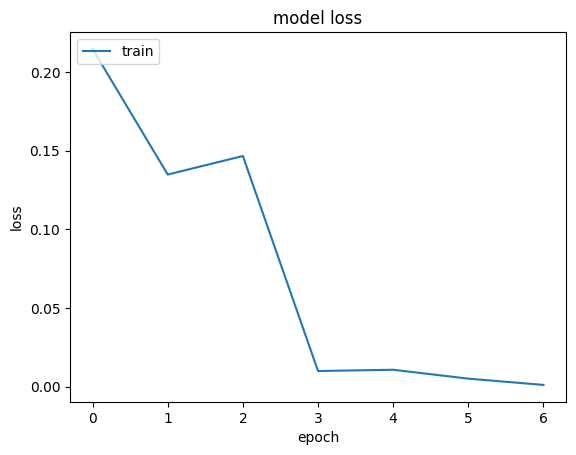

In [ ]:
# Skip the first 10 epochs (index 0 to 9) and start plotting from the 11th epoch (index 10)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# Adjusted the legend to include both 'train' and 'val' for clarity
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)


582/582 [==============================] - 54s 87ms/step


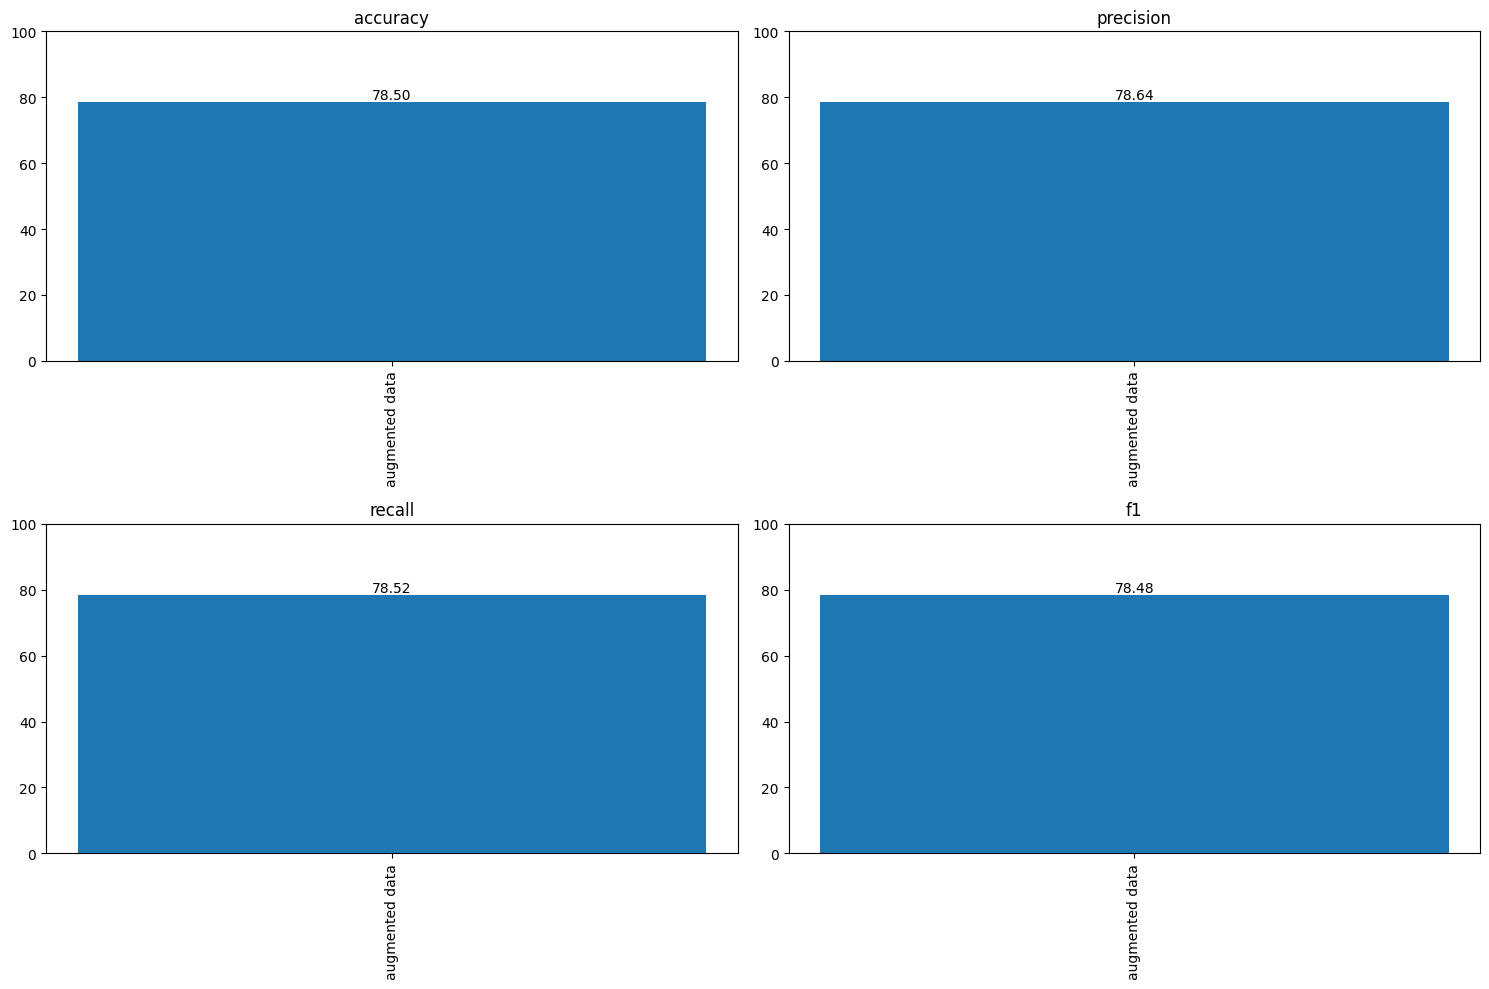

In [ ]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "augmented data")
metrics_val.plot()

### Data Augmentation: Synonyms from WordNet

I didn't choose to work with WordNet packages in the beginning, as far as synonyms look kind of random and don't usually properly reflect the meaning of the word (probably because of multiple meanings) and don't consider the context. But as far as I couldn't manually assign synonyms to all (or at least many) tokens, I decided to try WordNet as well.

So the second approach is to rendomly change 30% of the tokens in the comments (I tried different shares, 30% performed better) and add 32*20 (tried different numbers as well) new rows.

In [ ]:
# Function to get synonyms from WordNet
def get_wordnet_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return synonyms

# Function to replace random words with WordNet synonyms
def replace_with_synonym_wordnet(text):
    words = text.split()
    for i, word in enumerate(words):
        # Randomly decide whether to replace the word with a synonym
        if random.random() < 0.3:  # Adjust the probability as needed
            # Get WordNet synonyms for the word
            synonyms = get_wordnet_synonyms(word)
            if synonyms:
                # Randomly select a synonym
                new_word = random.choice(synonyms)
                # Replace the word with the selected synonym
                words[i] = new_word
    return ' '.join(words)

# Duplicate each row and replace random words with WordNet synonyms
new_rows = pd.DataFrame(columns=df_train_32.columns)
for idx, row in df_train_32.iterrows():
    for _ in range(20):  # Duplicate 20 times - can be adjusted as needed
        # Duplicate the row
        new_row = row.copy()
        # Replace random words in the 'clean_text' column with WordNet synonyms
        new_row['clean_text'] = replace_with_synonym_wordnet(row['clean_text'])
        # Append the new row to the DataFrame
        new_rows = new_rows.append(new_row, ignore_index=True)

# Display the new DataFrame with duplicated rows and random word replacements
print(new_rows.head())


<ipython-input-140-a44f8c0859a0>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(new_row, ignore_index=True)


                                                text label text_length  \
0  Ever something unbelievable, strange or weird ...     1          18   
1  Ever something unbelievable, strange or weird ...     1          18   
2  Ever something unbelievable, strange or weird ...     1          18   
3  Ever something unbelievable, strange or weird ...     1          18   
4  Ever something unbelievable, strange or weird ...     1          18   

                                          clean_text clean_emotions hashtag  \
0  ever something unbelievable , strange or weird...                          
1  ever something unbelievable , strange or Weird...                          
2  e'er something unbelievable , strange or weird...                          
3  always something unbelievable , strange or wei...                          
4  ever something unbelievable , strange or uncan...                          

                                        text_emotion  
0  ever something unbelie

From the printed first rows you actually may see (comparing text and clean text, which was duplicated), that synonyms are kind of weird.

In [ ]:
# Add new_rows to df_train_32
augmented_df = pd.concat([df_train_32, new_rows], ignore_index=True)

# Display the augmented DataFrame
print(augmented_df.shape)

(672, 7)


In [ ]:
augmented_df_data = augmented_df['clean_text']
augmented_df_label = augmented_df['label']

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(augmented_df_label).reshape(-1, 1)).toarray()

In [ ]:
# Define a custom generator function that yields batches and updates the tqdm progress bar
def tqdm_generator(generator, steps_per_epoch):
    for batch in tqdm(generator, total=steps_per_epoch, desc="Epoch"):
        yield batch

X_train = np.array(augmented_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
#bert_model.fit(batches_with_progress, epochs=7, steps_per_epoch=steps_per_epoch)

history = bert_model.fit(batches_with_progress, epochs=10, steps_per_epoch=steps_per_epoch)





Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/10





Epoch:   5%|▍         | 1/21 [00:24<08:03, 24.20s/it]

 1/21 [>.............................] - ETA: 12:39 - loss: 0.0058 - recall_3: 1.0000 - precision_3: 1.0000




Epoch:  14%|█▍        | 3/21 [00:38<03:25, 11.41s/it]

 2/21 [=>............................] - ETA: 6s - loss: 0.0771 - recall_3: 0.9688 - precision_3: 0.9688   




Epoch:  19%|█▉        | 4/21 [00:38<02:08,  7.58s/it]

 3/21 [===>..........................] - ETA: 6s - loss: 0.0971 - recall_3: 0.9688 - precision_3: 0.9688




Epoch:  24%|██▍       | 5/21 [00:38<01:23,  5.19s/it]

 4/21 [====>.........................] - ETA: 5s - loss: 0.0815 - recall_3: 0.9688 - precision_3: 0.9688




Epoch:  29%|██▊       | 6/21 [00:39<00:54,  3.64s/it]

 5/21 [======>.......................] - ETA: 5s - loss: 0.0687 - recall_3: 0.9750 - precision_3: 0.9750




Epoch:  33%|███▎      | 7/21 [00:39<00:36,  2.58s/it]

 6/21 [=======>......................] - ETA: 4s - loss: 0.0618 - recall_3: 0.9740 - precision_3: 0.9740




Epoch:  38%|███▊      | 8/21 [00:39<00:24,  1.87s/it]

 7/21 [=========>....................] - ETA: 4s - loss: 0.0534 - recall_3: 0.9777 - precision_3: 0.9777




Epoch:  43%|████▎     | 9/21 [00:39<00:16,  1.38s/it]

 8/21 [==========>...................] - ETA: 3s - loss: 0.0635 - recall_3: 0.9766 - precision_3: 0.9766




Epoch:  48%|████▊     | 10/21 [00:40<00:11,  1.04s/it]

 9/21 [===========>..................] - ETA: 3s - loss: 0.0571 - recall_3: 0.9792 - precision_3: 0.9792




Epoch:  52%|█████▏    | 11/21 [00:40<00:08,  1.25it/s]

10/21 [=============>................] - ETA: 3s - loss: 0.0517 - recall_3: 0.9812 - precision_3: 0.9812




Epoch:  57%|█████▋    | 12/21 [00:40<00:06,  1.49it/s]

11/21 [==============>...............] - ETA: 3s - loss: 0.0471 - recall_3: 0.9830 - precision_3: 0.9830




Epoch:  62%|██████▏   | 13/21 [00:41<00:04,  1.82it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0508 - recall_3: 0.9818 - precision_3: 0.9818




Epoch:  67%|██████▋   | 14/21 [00:41<00:03,  2.04it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0478 - recall_3: 0.9832 - precision_3: 0.9832




Epoch:  71%|███████▏  | 15/21 [00:41<00:02,  2.35it/s]

14/21 [===================>..........] - ETA: 2s - loss: 0.0490 - recall_3: 0.9821 - precision_3: 0.9821




Epoch:  76%|███████▌  | 16/21 [00:42<00:01,  2.66it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0473 - recall_3: 0.9833 - precision_3: 0.9833




Epoch:  81%|████████  | 17/21 [00:42<00:01,  2.88it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0463 - recall_3: 0.9824 - precision_3: 0.9824




Epoch:  86%|████████▌ | 18/21 [00:42<00:01,  2.85it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0554 - recall_3: 0.9816 - precision_3: 0.9816




Epoch:  90%|█████████ | 19/21 [00:42<00:00,  3.06it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0630 - recall_3: 0.9809 - precision_3: 0.9809




Epoch:  95%|█████████▌| 20/21 [00:43<00:00,  3.23it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0606 - recall_3: 0.9819 - precision_3: 0.9819




Epoch: 100%|██████████| 21/21 [00:43<00:00,  3.37it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0577 - recall_3: 0.9828 - precision_3: 0.9828




Epoch: 22it [00:43,  3.42it/s]                        

21/21 [==============================] - 44s 296ms/step - loss: 0.0561 - recall_3: 0.9836 - precision_3: 0.9836
Epoch 2/10





Epoch: 23it [00:44,  3.46it/s]

 1/21 [>.............................] - ETA: 5s - loss: 0.0059 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 24it [00:44,  3.54it/s]

 2/21 [=>............................] - ETA: 5s - loss: 0.0067 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 25it [00:44,  3.60it/s]

 3/21 [===>..........................] - ETA: 4s - loss: 0.0051 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 26it [00:44,  3.63it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 0.0097 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 27it [00:45,  3.63it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0084 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 28it [00:45,  3.66it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 0.0083 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 29it [00:45,  3.72it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 0.0078 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 30it [00:45,  3.68it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 0.0072 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 31it [00:46,  3.66it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 0.0066 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 32it [00:46,  3.65it/s]

10/21 [=============>................] - ETA: 2s - loss: 0.0067 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 33it [00:46,  3.71it/s]

11/21 [==============>...............] - ETA: 2s - loss: 0.0062 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 34it [00:46,  3.68it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0060 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 35it [00:47,  3.65it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0216 - recall_3: 0.9952 - precision_3: 0.9952




Epoch: 36it [00:47,  3.36it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0202 - recall_3: 0.9955 - precision_3: 0.9955




Epoch: 37it [00:47,  3.47it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0190 - recall_3: 0.9958 - precision_3: 0.9958




Epoch: 38it [00:48,  3.55it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0210 - recall_3: 0.9941 - precision_3: 0.9941




Epoch: 39it [00:48,  3.64it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0200 - recall_3: 0.9945 - precision_3: 0.9945




Epoch: 40it [00:48,  3.61it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0189 - recall_3: 0.9948 - precision_3: 0.9948




Epoch: 41it [00:48,  3.66it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0180 - recall_3: 0.9951 - precision_3: 0.9951




Epoch: 42it [00:49,  3.66it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0173 - recall_3: 0.9953 - precision_3: 0.9953




Epoch: 43it [00:49,  3.72it/s]

21/21 [==============================] - 6s 275ms/step - loss: 0.0165 - recall_3: 0.9955 - precision_3: 0.9955
Epoch 3/10





Epoch: 44it [00:49,  3.64it/s]

 1/21 [>.............................] - ETA: 5s - loss: 5.4132e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 45it [00:50,  3.70it/s]

 2/21 [=>............................] - ETA: 5s - loss: 5.9913e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 46it [00:50,  3.69it/s]

 3/21 [===>..........................] - ETA: 4s - loss: 0.0032 - recall_3: 1.0000 - precision_3: 1.0000    




Epoch: 47it [00:50,  3.70it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 0.0026 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 48it [00:50,  3.67it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0022 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 49it [00:51,  3.69it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 0.0019 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 50it [00:51,  3.69it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 0.0017 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 51it [00:51,  3.73it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 0.0015 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 52it [00:51,  3.75it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 0.0014 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 53it [00:52,  3.72it/s]

10/21 [=============>................] - ETA: 2s - loss: 0.0013 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 54it [00:52,  3.69it/s]

11/21 [==============>...............] - ETA: 2s - loss: 0.0025 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 55it [00:52,  3.73it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0024 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 56it [00:53,  3.70it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0022 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 57it [00:53,  3.69it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0021 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 58it [00:53,  3.72it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0020 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 59it [00:53,  3.70it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0021 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 60it [00:54,  3.71it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0020 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 61it [00:54,  3.72it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0019 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 62it [00:54,  3.74it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0018 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 63it [00:54,  3.73it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0018 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 64it [00:55,  3.70it/s]

21/21 [==============================] - 6s 270ms/step - loss: 0.0023 - recall_3: 1.0000 - precision_3: 1.0000
Epoch 4/10





Epoch: 65it [00:55,  3.67it/s]

 1/21 [>.............................] - ETA: 5s - loss: 0.0042 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 66it [00:55,  3.71it/s]

 2/21 [=>............................] - ETA: 5s - loss: 0.0025 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 67it [00:55,  3.70it/s]

 3/21 [===>..........................] - ETA: 4s - loss: 0.0017 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 68it [00:56,  3.66it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 0.0013 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 69it [00:56,  3.69it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0011 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 70it [00:56,  3.69it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 9.4948e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 71it [00:57,  3.69it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 8.6859e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 72it [00:57,  3.70it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 7.9619e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 73it [00:57,  3.68it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 7.3231e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 74it [00:57,  3.71it/s]

10/21 [=============>................] - ETA: 2s - loss: 8.0923e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 75it [00:58,  3.68it/s]

11/21 [==============>...............] - ETA: 2s - loss: 7.4902e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 76it [00:58,  3.71it/s]

12/21 [================>.............] - ETA: 2s - loss: 7.5500e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 77it [00:58,  3.70it/s]

13/21 [=================>............] - ETA: 2s - loss: 7.1095e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 78it [00:58,  3.69it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0095 - recall_3: 0.9978 - precision_3: 0.9978    




Epoch: 79it [00:59,  3.70it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0089 - recall_3: 0.9979 - precision_3: 0.9979




Epoch: 80it [00:59,  3.71it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0084 - recall_3: 0.9980 - precision_3: 0.9980




Epoch: 81it [00:59,  3.71it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0079 - recall_3: 0.9982 - precision_3: 0.9982




Epoch: 82it [01:00,  3.70it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0075 - recall_3: 0.9983 - precision_3: 0.9983




Epoch: 83it [01:00,  3.70it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0071 - recall_3: 0.9984 - precision_3: 0.9984




Epoch: 84it [01:00,  3.66it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0068 - recall_3: 0.9984 - precision_3: 0.9984




Epoch: 85it [01:00,  3.65it/s]

21/21 [==============================] - 6s 272ms/step - loss: 0.0065 - recall_3: 0.9985 - precision_3: 0.9985
Epoch 5/10





Epoch: 86it [01:01,  3.63it/s]

 1/21 [>.............................] - ETA: 5s - loss: 0.0024 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 87it [01:01,  3.67it/s]

 2/21 [=>............................] - ETA: 5s - loss: 0.0132 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 88it [01:01,  3.68it/s]

 3/21 [===>..........................] - ETA: 4s - loss: 0.0440 - recall_3: 0.9896 - precision_3: 0.9896




Epoch: 89it [01:01,  3.65it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 0.0333 - recall_3: 0.9922 - precision_3: 0.9922




Epoch: 90it [01:02,  3.68it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0267 - recall_3: 0.9937 - precision_3: 0.9937




Epoch: 91it [01:02,  3.67it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 0.0222 - recall_3: 0.9948 - precision_3: 0.9948




Epoch: 92it [01:02,  3.66it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 0.0191 - recall_3: 0.9955 - precision_3: 0.9955




Epoch: 93it [01:03,  3.67it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 0.0168 - recall_3: 0.9961 - precision_3: 0.9961




Epoch: 94it [01:03,  3.67it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 0.0149 - recall_3: 0.9965 - precision_3: 0.9965




Epoch: 95it [01:03,  3.64it/s]

10/21 [=============>................] - ETA: 3s - loss: 0.0136 - recall_3: 0.9969 - precision_3: 0.9969




Epoch: 96it [01:03,  3.66it/s]

11/21 [==============>...............] - ETA: 2s - loss: 0.0124 - recall_3: 0.9972 - precision_3: 0.9972




Epoch: 97it [01:04,  3.68it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0114 - recall_3: 0.9974 - precision_3: 0.9974




Epoch: 98it [01:04,  3.68it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0106 - recall_3: 0.9976 - precision_3: 0.9976




Epoch: 99it [01:04,  3.67it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0102 - recall_3: 0.9978 - precision_3: 0.9978




Epoch: 100it [01:04,  3.68it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0097 - recall_3: 0.9979 - precision_3: 0.9979




Epoch: 101it [01:05,  3.68it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0091 - recall_3: 0.9980 - precision_3: 0.9980




Epoch: 102it [01:05,  3.66it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0086 - recall_3: 0.9982 - precision_3: 0.9982




Epoch: 103it [01:05,  3.65it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0081 - recall_3: 0.9983 - precision_3: 0.9983




Epoch: 104it [01:06,  3.65it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0094 - recall_3: 0.9967 - precision_3: 0.9967




Epoch: 105it [01:06,  3.65it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0089 - recall_3: 0.9969 - precision_3: 0.9969




Epoch: 106it [01:06,  3.64it/s]

21/21 [==============================] - 6s 278ms/step - loss: 0.0085 - recall_3: 0.9970 - precision_3: 0.9970
Epoch 6/10





Epoch: 107it [01:06,  3.31it/s]

 1/21 [>.............................] - ETA: 5s - loss: 3.9161e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 108it [01:07,  3.44it/s]

 2/21 [=>............................] - ETA: 5s - loss: 2.7946e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 109it [01:07,  3.52it/s]

 3/21 [===>..........................] - ETA: 4s - loss: 2.4160e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 110it [01:07,  3.57it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 4.4273e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 111it [01:08,  3.54it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 4.1214e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 112it [01:08,  3.58it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 5.9543e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 113it [01:08,  3.59it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 5.5123e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 114it [01:08,  3.60it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 5.6503e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 115it [01:09,  3.61it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 5.7693e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 116it [01:09,  3.63it/s]

10/21 [=============>................] - ETA: 3s - loss: 6.2051e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 117it [01:09,  3.59it/s]

11/21 [==============>...............] - ETA: 2s - loss: 5.7183e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 118it [01:09,  3.61it/s]

12/21 [================>.............] - ETA: 2s - loss: 5.3075e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 119it [01:10,  3.59it/s]

13/21 [=================>............] - ETA: 2s - loss: 4.9413e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 120it [01:10,  3.59it/s]

14/21 [===================>..........] - ETA: 1s - loss: 4.8683e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 121it [01:10,  3.61it/s]

15/21 [====================>.........] - ETA: 1s - loss: 4.9256e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 122it [01:11,  3.63it/s]

16/21 [=====================>........] - ETA: 1s - loss: 4.7235e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 123it [01:11,  3.63it/s]

17/21 [=======================>......] - ETA: 1s - loss: 4.5964e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 124it [01:11,  3.63it/s]

18/21 [========================>.....] - ETA: 0s - loss: 5.1893e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 125it [01:11,  3.64it/s]

19/21 [==========================>...] - ETA: 0s - loss: 5.0479e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 126it [01:12,  3.62it/s]

20/21 [===========================>..] - ETA: 0s - loss: 5.0353e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 127it [01:12,  3.62it/s]

21/21 [==============================] - 6s 276ms/step - loss: 4.8449e-04 - recall_3: 1.0000 - precision_3: 1.0000
Epoch 7/10





Epoch: 128it [01:12,  3.60it/s]

 1/21 [>.............................] - ETA: 5s - loss: 3.0613e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 129it [01:13,  3.64it/s]

 2/21 [=>............................] - ETA: 5s - loss: 1.8636e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 130it [01:13,  3.65it/s]

 3/21 [===>..........................] - ETA: 4s - loss: 2.0954e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 131it [01:13,  3.66it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 3.0365e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 132it [01:13,  3.65it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 2.9615e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 133it [01:14,  3.67it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 2.8848e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 134it [01:14,  3.68it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 3.2913e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 135it [01:14,  3.68it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 4.8431e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 136it [01:14,  3.68it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 4.5998e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 137it [01:15,  3.68it/s]

10/21 [=============>................] - ETA: 2s - loss: 4.1877e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 138it [01:15,  3.68it/s]

11/21 [==============>...............] - ETA: 2s - loss: 0.0105 - recall_3: 0.9972 - precision_3: 0.9972    




Epoch: 139it [01:15,  3.68it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0096 - recall_3: 0.9974 - precision_3: 0.9974




Epoch: 140it [01:16,  3.68it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0089 - recall_3: 0.9976 - precision_3: 0.9976




Epoch: 141it [01:16,  3.69it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0083 - recall_3: 0.9978 - precision_3: 0.9978




Epoch: 142it [01:16,  3.69it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0078 - recall_3: 0.9979 - precision_3: 0.9979




Epoch: 143it [01:16,  3.69it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0083 - recall_3: 0.9980 - precision_3: 0.9980




Epoch: 144it [01:17,  3.70it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0078 - recall_3: 0.9982 - precision_3: 0.9982




Epoch: 145it [01:17,  3.70it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0074 - recall_3: 0.9983 - precision_3: 0.9983




Epoch: 146it [01:17,  3.70it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0070 - recall_3: 0.9984 - precision_3: 0.9984




Epoch: 147it [01:17,  3.70it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0067 - recall_3: 0.9984 - precision_3: 0.9984




Epoch: 148it [01:18,  3.71it/s]

21/21 [==============================] - 6s 272ms/step - loss: 0.0065 - recall_3: 0.9985 - precision_3: 0.9985
Epoch 8/10





Epoch: 149it [01:18,  3.64it/s]

 1/21 [>.............................] - ETA: 5s - loss: 0.0122 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 150it [01:18,  3.68it/s]

 2/21 [=>............................] - ETA: 5s - loss: 0.0085 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 151it [01:18,  3.69it/s]

 3/21 [===>..........................] - ETA: 4s - loss: 0.0057 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 152it [01:19,  3.70it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 0.0044 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 153it [01:19,  3.69it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0035 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 154it [01:19,  3.71it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 0.0030 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 155it [01:20,  3.72it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 0.0026 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 156it [01:20,  3.67it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 0.0023 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 157it [01:20,  3.66it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 0.0020 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 158it [01:20,  3.69it/s]

10/21 [=============>................] - ETA: 2s - loss: 0.0018 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 159it [01:21,  3.71it/s]

11/21 [==============>...............] - ETA: 2s - loss: 0.0017 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 160it [01:21,  3.69it/s]

12/21 [================>.............] - ETA: 2s - loss: 0.0016 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 161it [01:21,  3.71it/s]

13/21 [=================>............] - ETA: 2s - loss: 0.0015 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 162it [01:21,  3.72it/s]

14/21 [===================>..........] - ETA: 1s - loss: 0.0014 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 163it [01:22,  3.73it/s]

15/21 [====================>.........] - ETA: 1s - loss: 0.0013 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 164it [01:22,  3.73it/s]

16/21 [=====================>........] - ETA: 1s - loss: 0.0012 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 165it [01:22,  3.73it/s]

17/21 [=======================>......] - ETA: 1s - loss: 0.0012 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 166it [01:23,  3.73it/s]

18/21 [========================>.....] - ETA: 0s - loss: 0.0012 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 167it [01:23,  3.74it/s]

19/21 [==========================>...] - ETA: 0s - loss: 0.0011 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 168it [01:23,  3.74it/s]

20/21 [===========================>..] - ETA: 0s - loss: 0.0011 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 169it [01:23,  3.71it/s]

21/21 [==============================] - 6s 269ms/step - loss: 0.0010 - recall_3: 1.0000 - precision_3: 1.0000
Epoch 9/10





Epoch: 170it [01:24,  3.70it/s]

 1/21 [>.............................] - ETA: 5s - loss: 8.3876e-05 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 171it [01:24,  3.72it/s]

 2/21 [=>............................] - ETA: 5s - loss: 0.0029 - recall_3: 1.0000 - precision_3: 1.0000    




Epoch: 172it [01:24,  3.71it/s]

 3/21 [===>..........................] - ETA: 4s - loss: 0.0020 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 173it [01:24,  3.72it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 0.0016 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 174it [01:25,  3.73it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 0.0013 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 175it [01:25,  3.73it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 0.0011 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 176it [01:25,  3.73it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 9.9095e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 177it [01:25,  3.74it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 8.8553e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 178it [01:26,  3.74it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 7.9436e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 179it [01:26,  3.74it/s]

10/21 [=============>................] - ETA: 2s - loss: 7.3093e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 180it [01:26,  3.73it/s]

11/21 [==============>...............] - ETA: 2s - loss: 6.7424e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 181it [01:27,  3.73it/s]

12/21 [================>.............] - ETA: 2s - loss: 6.3063e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 182it [01:27,  3.74it/s]

13/21 [=================>............] - ETA: 2s - loss: 5.8900e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 183it [01:27,  3.75it/s]

14/21 [===================>..........] - ETA: 1s - loss: 5.5942e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 184it [01:27,  3.75it/s]

15/21 [====================>.........] - ETA: 1s - loss: 5.3008e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 185it [01:28,  3.75it/s]

16/21 [=====================>........] - ETA: 1s - loss: 5.0537e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 186it [01:28,  3.73it/s]

17/21 [=======================>......] - ETA: 1s - loss: 4.9183e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 187it [01:28,  3.72it/s]

18/21 [========================>.....] - ETA: 0s - loss: 5.0114e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 188it [01:28,  3.74it/s]

19/21 [==========================>...] - ETA: 0s - loss: 4.7650e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 189it [01:29,  3.73it/s]

20/21 [===========================>..] - ETA: 0s - loss: 4.5401e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 190it [01:29,  3.75it/s]

21/21 [==============================] - 6s 268ms/step - loss: 4.3591e-04 - recall_3: 1.0000 - precision_3: 1.0000
Epoch 10/10





Epoch: 191it [01:29,  3.70it/s]

 1/21 [>.............................] - ETA: 5s - loss: 5.3749e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 192it [01:29,  3.73it/s]

 2/21 [=>............................] - ETA: 5s - loss: 2.8351e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 193it [01:30,  3.74it/s]

 3/21 [===>..........................] - ETA: 4s - loss: 2.3489e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 194it [01:30,  3.75it/s]

 4/21 [====>.........................] - ETA: 4s - loss: 1.8025e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 195it [01:30,  3.74it/s]

 5/21 [======>.......................] - ETA: 4s - loss: 1.9635e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 196it [01:31,  3.75it/s]

 6/21 [=======>......................] - ETA: 4s - loss: 1.7042e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 197it [01:31,  3.73it/s]

 7/21 [=========>....................] - ETA: 3s - loss: 1.5122e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 198it [01:31,  3.75it/s]

 8/21 [==========>...................] - ETA: 3s - loss: 1.6326e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 199it [01:31,  3.75it/s]

 9/21 [===========>..................] - ETA: 3s - loss: 1.6840e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 200it [01:32,  3.76it/s]

10/21 [=============>................] - ETA: 2s - loss: 1.5382e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 201it [01:32,  3.78it/s]

11/21 [==============>...............] - ETA: 2s - loss: 1.4509e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 202it [01:32,  3.74it/s]

12/21 [================>.............] - ETA: 2s - loss: 1.3702e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 203it [01:32,  3.76it/s]

13/21 [=================>............] - ETA: 2s - loss: 1.3238e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 204it [01:33,  3.77it/s]

14/21 [===================>..........] - ETA: 1s - loss: 1.2625e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 205it [01:33,  3.71it/s]

15/21 [====================>.........] - ETA: 1s - loss: 1.3256e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 206it [01:33,  3.74it/s]

16/21 [=====================>........] - ETA: 1s - loss: 1.3149e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 207it [01:33,  3.75it/s]

17/21 [=======================>......] - ETA: 1s - loss: 1.3029e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 208it [01:34,  3.72it/s]

18/21 [========================>.....] - ETA: 0s - loss: 1.2814e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 209it [01:34,  3.74it/s]

19/21 [==========================>...] - ETA: 0s - loss: 1.2242e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 210it [01:34,  3.76it/s]

20/21 [===========================>..] - ETA: 0s - loss: 1.1832e-04 - recall_3: 1.0000 - precision_3: 1.0000




Epoch: 211it [01:35,  3.76it/s]

21/21 [==============================] - 6s 267ms/step - loss: 1.1639e-04 - recall_3: 1.0000 - precision_3: 1.0000


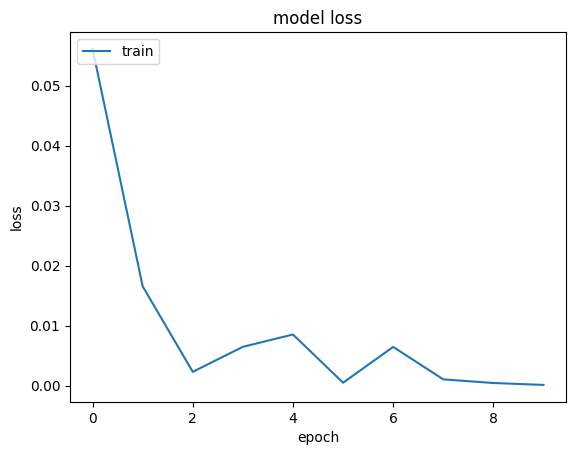

In [ ]:
# Skip the first 10 epochs (index 0 to 9) and start plotting from the 11th epoch (index 10)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# Adjusted the legend to include both 'train' and 'val' for clarity
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)


582/582 [==============================] - 53s 86ms/step


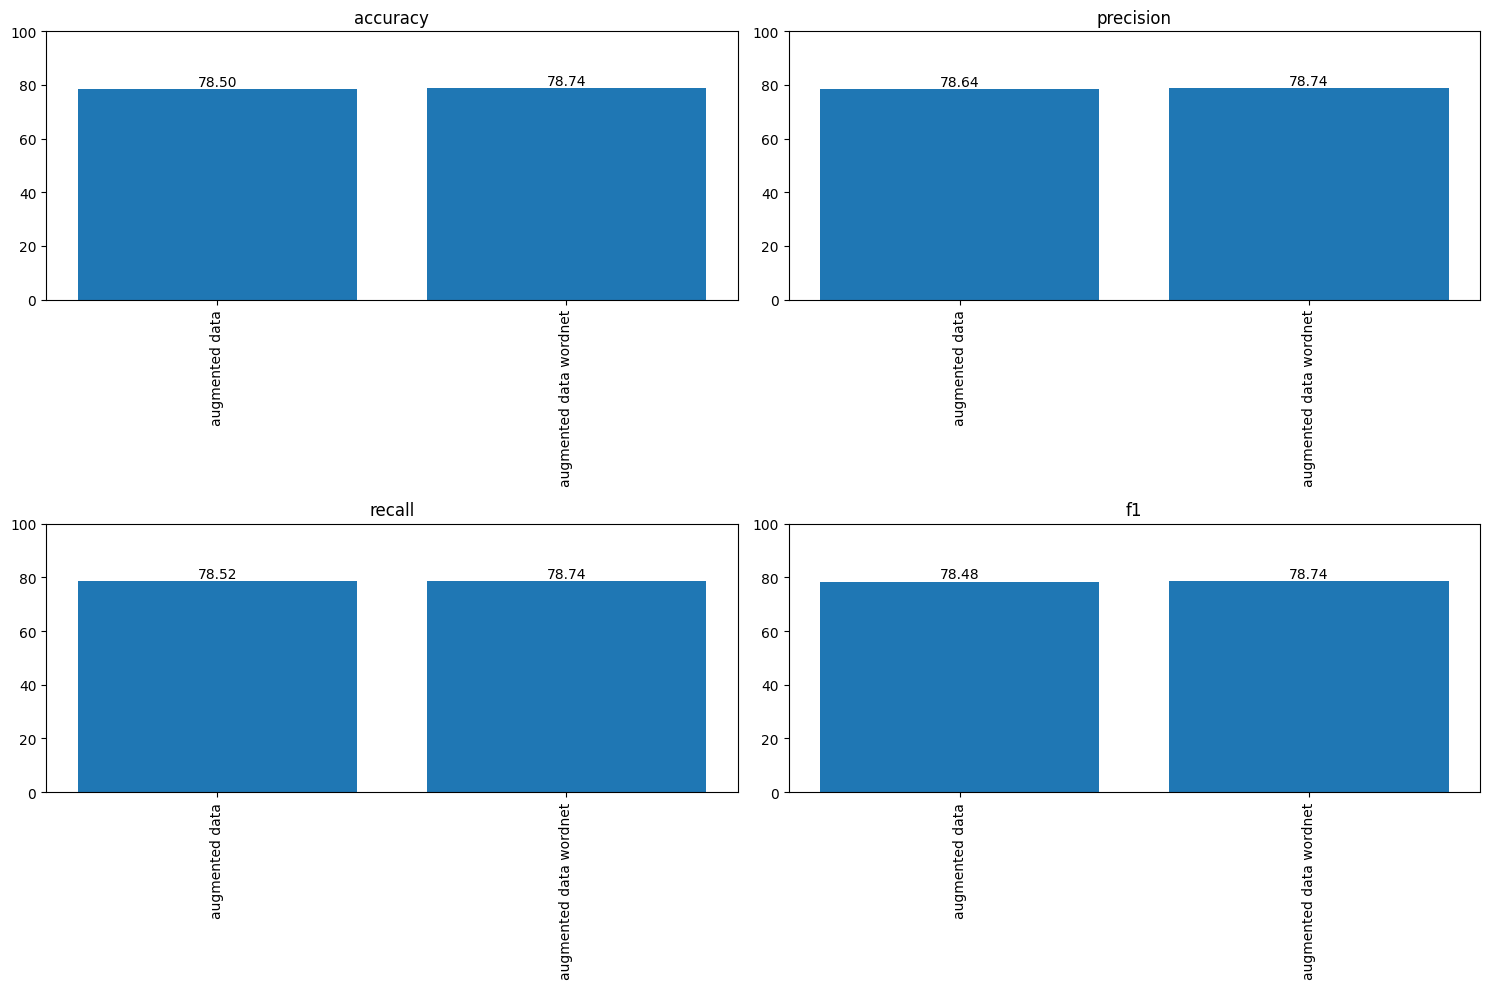

In [ ]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "augmented data wordnet")
metrics_val.plot()

---

# Zero-Shot Learning with LLM 

In [ ]:
import random
from transformers import pipeline

model_name = "facebook/bart-large-mnli"  # Adjust model name as needed

df_val_sampled = df_val.sample(n=300, random_state=42)
sampled_list1 = (df_val_sampled['text']).tolist()

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model=model_name)

# Define the candidate labels
candidate_labels = ['positive', 'negative']

# Store the predictions for each item in a list
predictions = []

# Iterate over each text sample in test_data
for text_sample in sampled_list1:
    # Use the classifier pipeline to predict the label
    result = classifier(text_sample, candidate_labels)

    # Get the label with the highest score
    if result['scores'][0] >= result['scores'][1]:
        predicted_label = result['labels'][0]
    else:
        predicted_label = result['labels'][1]

    # Append the predicted label to the predictions list
    predictions.append(predicted_label)

# Print the predictions
print(predictions)

['negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'ne

In [ ]:
zero_predictions = [1 if prediction == 'positive' else 0 for prediction in predictions]

# Update the "label" column with values from sampled_list2
df_val_sampled['label'] = zero_predictions

# Display the updated DataFrame
print(df_val_sampled.head())

                                                   text  label  text_length  \
1376  Season 3 of the Office isn't that funny becaus...      0           24   
932   I have had a very productive day...now I'm goi...      1           14   
144   Actually...I COULD leave her in the shed...for...      1           20   
1752               @SmashiesGurl I'm glad you're happy!      1            5   
51    @goodvybe ok ok I wanna go!!! Damn it...... I'...      0           12   

                                             clean_text clean_emotions  \
1376  season of the office is not that funny because...                  
932   i have had a very productive day . now i am go...                  
144   actually . i could leave her in the shed . for...                  
1752                          i am glad you are happy !                  
51     ok ok i wanna go ! damn it . i am sad now hahaha                  

     hashtag                                       text_emotion  
1376          

In [ ]:
# Add new_rows to df_train_32
augmented_zero_df = pd.concat([df_train_32, df_val_sampled], ignore_index=True)

# Display the augmented DataFrame
print(augmented_zero_df.shape)

(332, 8)


In [ ]:
augmented_zero_df_data = augmented_zero_df['clean_text']
augmented_zero_df_label = augmented_zero_df['label']

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(augmented_zero_df_label).reshape(-1, 1)).toarray()

In [ ]:
# Define a custom generator function that yields batches and updates the tqdm progress bar
def tqdm_generator(generator, steps_per_epoch):
    for batch in tqdm(generator, total=steps_per_epoch, desc="Epoch"):
        yield batch

X_train = np.array(augmented_zero_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=7, steps_per_epoch=steps_per_epoch)





Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/7





Epoch:  10%|█         | 1/10 [00:16<02:28, 16.45s/it]

 1/10 [==>...........................] - ETA: 3:42 - loss: 1.4398 - recall_3: 0.5938 - precision_3: 0.5938




Epoch:  30%|███       | 3/10 [00:24<00:51,  7.36s/it]

 2/10 [=====>........................] - ETA: 2s - loss: 1.4859 - recall_3: 0.5938 - precision_3: 0.5938  




Epoch:  40%|████      | 4/10 [00:25<00:29,  4.91s/it]

 3/10 [========>.....................] - ETA: 1s - loss: 1.6634 - recall_3: 0.6146 - precision_3: 0.6146




Epoch:  50%|█████     | 5/10 [00:25<00:16,  3.36s/it]

 4/10 [===========>..................] - ETA: 1s - loss: 1.6934 - recall_3: 0.6406 - precision_3: 0.6406




Epoch:  60%|██████    | 6/10 [00:25<00:09,  2.35s/it]

 5/10 [==============>...............] - ETA: 1s - loss: 1.5871 - recall_3: 0.6625 - precision_3: 0.6625




Epoch:  70%|███████   | 7/10 [00:25<00:05,  1.68s/it]

 6/10 [=================>............] - ETA: 0s - loss: 1.5711 - recall_3: 0.6667 - precision_3: 0.6667




Epoch:  80%|████████  | 8/10 [00:25<00:02,  1.23s/it]

 7/10 [====================>.........] - ETA: 0s - loss: 1.5031 - recall_3: 0.6696 - precision_3: 0.6696




Epoch:  90%|█████████ | 9/10 [00:26<00:00,  1.07it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 1.4600 - recall_3: 0.6680 - precision_3: 0.6680




Epoch: 100%|██████████| 10/10 [00:26<00:00,  1.37it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 1.3938 - recall_3: 0.6667 - precision_3: 0.6667




Epoch: 11it [00:26,  1.72it/s]                        

10/10 [==============================] - 27s 239ms/step - loss: 1.3177 - recall_3: 0.6719 - precision_3: 0.6719
Epoch 2/7





Epoch: 12it [00:26,  2.11it/s]

 1/10 [==>...........................] - ETA: 3s - loss: 0.7995 - recall_3: 0.9167 - precision_3: 0.9167




Epoch: 13it [00:27,  2.28it/s]

 2/10 [=====>........................] - ETA: 2s - loss: 0.5824 - recall_3: 0.7955 - precision_3: 0.7955




Epoch: 14it [00:27,  2.57it/s]

 3/10 [========>.....................] - ETA: 1s - loss: 0.5510 - recall_3: 0.8026 - precision_3: 0.8026




Epoch: 15it [00:27,  2.79it/s]

 4/10 [===========>..................] - ETA: 1s - loss: 0.5764 - recall_3: 0.7778 - precision_3: 0.7778




Epoch: 16it [00:28,  3.17it/s]

 5/10 [==============>...............] - ETA: 1s - loss: 0.5059 - recall_3: 0.8071 - precision_3: 0.8071




Epoch: 17it [00:28,  3.51it/s]

 6/10 [=================>............] - ETA: 0s - loss: 0.5455 - recall_3: 0.8081 - precision_3: 0.8081




Epoch: 18it [00:28,  3.79it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.5435 - recall_3: 0.8088 - precision_3: 0.8088




Epoch: 19it [00:28,  4.01it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.5175 - recall_3: 0.8093 - precision_3: 0.8093




Epoch: 20it [00:28,  4.17it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.4817 - recall_3: 0.8209 - precision_3: 0.8209




Epoch: 21it [00:29,  4.30it/s]

10/10 [==============================] - 2s 231ms/step - loss: 0.4904 - recall_3: 0.8100 - precision_3: 0.8100
Epoch 3/7





Epoch: 22it [00:29,  4.33it/s]

 1/10 [==>...........................] - ETA: 1s - loss: 0.4313 - recall_3: 0.8125 - precision_3: 0.8125




Epoch: 23it [00:29,  4.40it/s]

 2/10 [=====>........................] - ETA: 1s - loss: 0.4404 - recall_3: 0.8182 - precision_3: 0.8182




Epoch: 24it [00:29,  4.82it/s]

 3/10 [========>.....................] - ETA: 1s - loss: 0.6071 - recall_3: 0.7500 - precision_3: 0.7500




Epoch: 25it [00:29,  4.79it/s]

 4/10 [===========>..................] - ETA: 1s - loss: 0.5391 - recall_3: 0.7778 - precision_3: 0.7778




Epoch: 26it [00:30,  4.78it/s]

 5/10 [==============>...............] - ETA: 0s - loss: 0.5343 - recall_3: 0.7786 - precision_3: 0.7786




Epoch: 27it [00:30,  4.73it/s]

 6/10 [=================>............] - ETA: 0s - loss: 0.4786 - recall_3: 0.8023 - precision_3: 0.8023




Epoch: 28it [00:30,  4.68it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.4448 - recall_3: 0.8039 - precision_3: 0.8039




Epoch: 29it [00:30,  4.63it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.4251 - recall_3: 0.8093 - precision_3: 0.8093




Epoch: 30it [00:31,  4.64it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.4060 - recall_3: 0.8172 - precision_3: 0.8172




Epoch: 31it [00:31,  4.66it/s]

10/10 [==============================] - 2s 210ms/step - loss: 0.4023 - recall_3: 0.8167 - precision_3: 0.8167
Epoch 4/7





Epoch: 32it [00:31,  4.58it/s]

 1/10 [==>...........................] - ETA: 1s - loss: 0.2874 - recall_3: 0.8750 - precision_3: 0.8750




Epoch: 33it [00:31,  4.63it/s]

 2/10 [=====>........................] - ETA: 1s - loss: 0.2777 - recall_3: 0.8906 - precision_3: 0.8906




Epoch: 34it [00:31,  4.63it/s]

 3/10 [========>.....................] - ETA: 1s - loss: 0.2854 - recall_3: 0.8816 - precision_3: 0.8816




Epoch: 35it [00:32,  5.08it/s]

 4/10 [===========>..................] - ETA: 1s - loss: 0.3048 - recall_3: 0.8704 - precision_3: 0.8704




Epoch: 36it [00:32,  4.95it/s]

 5/10 [==============>...............] - ETA: 0s - loss: 0.2742 - recall_3: 0.8786 - precision_3: 0.8786




Epoch: 37it [00:32,  4.87it/s]

 6/10 [=================>............] - ETA: 0s - loss: 0.2703 - recall_3: 0.8895 - precision_3: 0.8895




Epoch: 38it [00:32,  4.81it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.2505 - recall_3: 0.9020 - precision_3: 0.9020




Epoch: 39it [00:32,  4.73it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.2444 - recall_3: 0.8983 - precision_3: 0.8983




Epoch: 40it [00:33,  4.67it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.2406 - recall_3: 0.9030 - precision_3: 0.9030




Epoch: 41it [00:33,  4.67it/s]

10/10 [==============================] - 2s 210ms/step - loss: 0.2601 - recall_3: 0.8933 - precision_3: 0.8933
Epoch 5/7





Epoch: 42it [00:33,  4.58it/s]

 1/10 [==>...........................] - ETA: 1s - loss: 0.1392 - recall_3: 0.9375 - precision_3: 0.9375




Epoch: 43it [00:33,  4.61it/s]

 2/10 [=====>........................] - ETA: 1s - loss: 0.1614 - recall_3: 0.9375 - precision_3: 0.9375




Epoch: 44it [00:34,  4.62it/s]

 3/10 [========>.....................] - ETA: 1s - loss: 0.1997 - recall_3: 0.9167 - precision_3: 0.9167




Epoch: 45it [00:34,  4.64it/s]

 4/10 [===========>..................] - ETA: 1s - loss: 0.2541 - recall_3: 0.9074 - precision_3: 0.9074




Epoch: 46it [00:34,  5.03it/s]

 5/10 [==============>...............] - ETA: 0s - loss: 0.2422 - recall_3: 0.8929 - precision_3: 0.8929




Epoch: 47it [00:34,  4.96it/s]

 6/10 [=================>............] - ETA: 0s - loss: 0.2280 - recall_3: 0.9012 - precision_3: 0.9012




Epoch: 48it [00:34,  4.74it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.2068 - recall_3: 0.9118 - precision_3: 0.9118




Epoch: 49it [00:35,  4.67it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.1977 - recall_3: 0.9153 - precision_3: 0.9153




Epoch: 50it [00:35,  4.65it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.1959 - recall_3: 0.9142 - precision_3: 0.9142




Epoch: 51it [00:35,  4.64it/s]

10/10 [==============================] - 2s 213ms/step - loss: 0.1910 - recall_3: 0.9200 - precision_3: 0.9200
Epoch 6/7





Epoch: 52it [00:35,  4.51it/s]

 1/10 [==>...........................] - ETA: 1s - loss: 0.0994 - recall_3: 0.9688 - precision_3: 0.9688




Epoch: 53it [00:35,  4.58it/s]

 2/10 [=====>........................] - ETA: 1s - loss: 0.1281 - recall_3: 0.9688 - precision_3: 0.9688




Epoch: 54it [00:36,  4.61it/s]

 3/10 [========>.....................] - ETA: 1s - loss: 0.2025 - recall_3: 0.9375 - precision_3: 0.9375




Epoch: 55it [00:36,  4.59it/s]

 4/10 [===========>..................] - ETA: 1s - loss: 0.1738 - recall_3: 0.9531 - precision_3: 0.9531




Epoch: 56it [00:36,  4.58it/s]

 5/10 [==============>...............] - ETA: 1s - loss: 0.1631 - recall_3: 0.9571 - precision_3: 0.9571




Epoch: 57it [00:36,  4.95it/s]

 6/10 [=================>............] - ETA: 0s - loss: 0.1552 - recall_3: 0.9593 - precision_3: 0.9593




Epoch: 58it [00:36,  4.85it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.1499 - recall_3: 0.9559 - precision_3: 0.9559




Epoch: 59it [00:37,  4.77it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.1441 - recall_3: 0.9576 - precision_3: 0.9576




Epoch: 60it [00:37,  4.73it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.1497 - recall_3: 0.9552 - precision_3: 0.9552




Epoch: 61it [00:37,  4.68it/s]

10/10 [==============================] - 2s 213ms/step - loss: 0.1440 - recall_3: 0.9567 - precision_3: 0.9567
Epoch 7/7





Epoch: 62it [00:37,  4.49it/s]

 1/10 [==>...........................] - ETA: 3s - loss: 0.1537 - recall_3: 0.9688 - precision_3: 0.9688




Epoch: 63it [00:38,  3.66it/s]

 2/10 [=====>........................] - ETA: 3s - loss: 0.1294 - recall_3: 0.9688 - precision_3: 0.9688




Epoch: 64it [00:38,  3.12it/s]

 3/10 [========>.....................] - ETA: 3s - loss: 0.1053 - recall_3: 0.9792 - precision_3: 0.9792




Epoch: 65it [00:39,  2.68it/s]

 4/10 [===========>..................] - ETA: 2s - loss: 0.1216 - recall_3: 0.9766 - precision_3: 0.9766




Epoch: 66it [00:39,  2.60it/s]

 5/10 [==============>...............] - ETA: 1s - loss: 0.1083 - recall_3: 0.9750 - precision_3: 0.9750




Epoch: 67it [00:39,  2.88it/s]

 6/10 [=================>............] - ETA: 1s - loss: 0.1072 - recall_3: 0.9767 - precision_3: 0.9767




Epoch: 68it [00:40,  3.53it/s]

 7/10 [====================>.........] - ETA: 0s - loss: 0.1004 - recall_3: 0.9804 - precision_3: 0.9804




Epoch: 69it [00:40,  3.71it/s]

 8/10 [=======================>......] - ETA: 0s - loss: 0.0929 - recall_3: 0.9831 - precision_3: 0.9831




Epoch: 70it [00:40,  3.86it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.0945 - recall_3: 0.9813 - precision_3: 0.9813




Epoch: 71it [00:40,  3.41it/s]

10/10 [==============================] - 3s 313ms/step - loss: 0.0862 - recall_3: 0.9833 - precision_3: 0.9833


In [ ]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(validation_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)


94/94 [==============================] - 8s 73ms/step


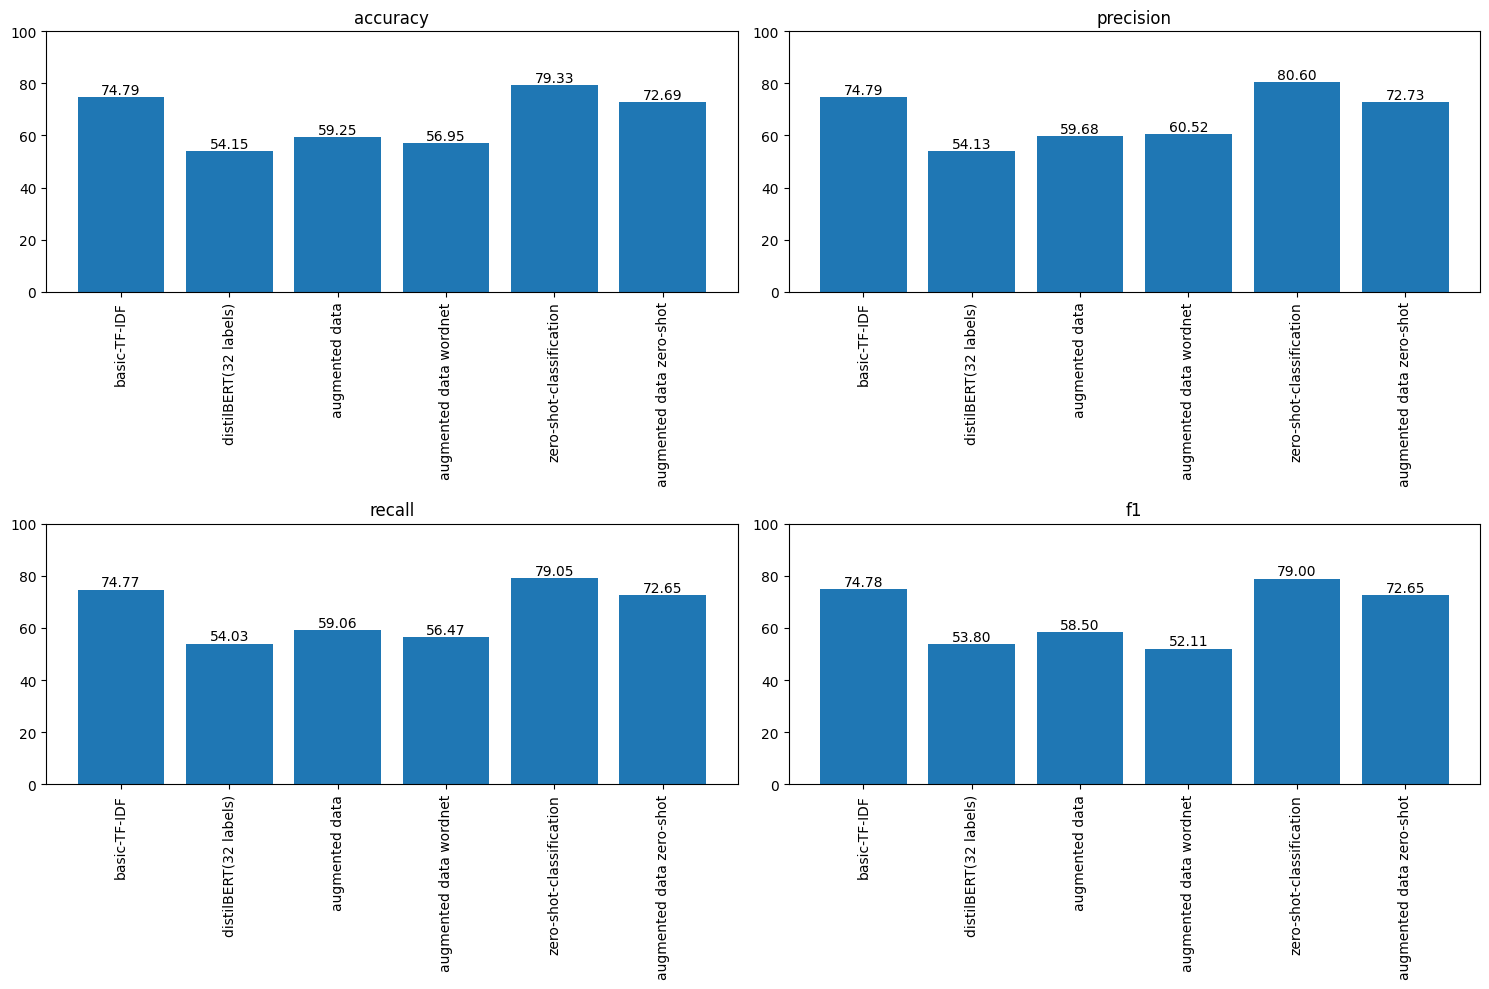

In [ ]:
# get the final metrics
metrics_val.run(validation_labels, valid_preds, "augmented data zero-shot")
metrics_val.plot()

---

# Data Generation with LLM (1 point)

### Use a large language model to generate new, labeled dataset points. Analyze how this impacts model metrics.

In [ ]:
!pip install openai
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.9/262.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.5/810.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24

In [ ]:
import os
from openai import OpenAI
from jinja2 import Template
from tqdm import tqdm
from collections import Counter

from langchain.chat_models import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

api_key = []

In [ ]:
# Output path to keep the generated answers:
path_output = []

prompts = []

initial_prompt = """
Title: Twitter Sentiment Analysis Data Generation

Description: In this project, the goal is to classify the sentiment of tweets as either positive (1) or negative (0).
We have a dataset called TSATC (Twitter Sentiment Analysis Training Corpus). Each tweet is labeled with either a 1 for positive sentiment or a 0 for negative sentiment.

Task: We aim to enhance our dataset by generating new labeled data points using a Large Language Model (LLM).
By leveraging the capabilities of LLMs, we seek to create additional labeled examples to improve the performance of our sentiment analysis model.

Prompt:
Given the context provided above, you will be asked to generate new tweets with sentiment labels (1 for positive sentiment, 0 for negative sentiment).
You can use the existing tweets as inspiration to generate new ones, ensuring that the generated tweets reflect similar sentiment patterns.
The generated tweets should maintain relevance to real-world Twitter content and adhere to the sentiment labeling scheme.

Additional Instructions:
- Ensure that the generated tweets are coherent, grammatically correct, and resemble natural Twitter language.
- Aim for diversity in the generated tweets to cover a wide range of sentiment expressions.
- Pay attention to the sentiment labels assigned to each generated tweet, maintaining consistency with the labeling scheme.

Data Format:
- Each generated tweet should be accompanied by its corresponding sentiment label (1 for positive, 0 for negative) and the context.
- Output format: Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]

Example Output:
Tweet_: "Just finished watching the latest episode of my favorite TV show! Absolutely loved it!" Sentiment_: 1 Context_: "Normal"
Tweet_: "Stuck in traffic again! This commute is unbearable." Sentiment_: 0 Context_: "Normal"

The next ("PROMPT") will follow this structure:
"Please generate {{number}} {{sentiment}} tweets with the following context {{context}}. Return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]"

Where Number is equal to the number of tweets to generate, Sentiment will be positive or negative.
And Context will be one of the following options [Normal, Sarcasm, Irony] where you adapt the generated tweets to the given context.
"""

following_prompts = """
Please generate {{number}} {{sentiment}} tweets with the following context {{context}}. Only return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]
"""

following_prompts = Template(following_prompts)
sentiment_list = ["positive","negative"]
context_list = ['Normal','Normal','Sarcasm','Irony'] # Two times 'Normal' to have more of these

In [ ]:
print(initial_prompt)


Title: Twitter Sentiment Analysis Data Generation

Description: In this project, the goal is to classify the sentiment of tweets as either positive (1) or negative (0).
We have a dataset called TSATC (Twitter Sentiment Analysis Training Corpus). Each tweet is labeled with either a 1 for positive sentiment or a 0 for negative sentiment.

Task: We aim to enhance our dataset by generating new labeled data points using a Large Language Model (LLM).
By leveraging the capabilities of LLMs, we seek to create additional labeled examples to improve the performance of our sentiment analysis model.

Prompt:
Given the context provided above, you will be asked to generate new tweets with sentiment labels (1 for positive sentiment, 0 for negative sentiment).
You can use the existing tweets as inspiration to generate new ones, ensuring that the generated tweets reflect similar sentiment patterns.
The generated tweets should maintain relevance to real-world Twitter content and adhere to the sentiment

In [ ]:
print(following_prompts.render(number=50, sentiment="positive", context="Normal"))


Please generate 50 positive tweets with the following context Normal. Only return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]


In [ ]:
#client = OpenAI(api_key=tatiana_key)

In [ ]:
# As only 50 tweets are asked in each prompt, we multiply the number of demands by 3.
all_prompts = [initial_prompt] + 3*[following_prompts.render(number=50,sentiment="negative", context=con) for con in context_list] + 3*[following_prompts.render(number=50,sentiment="positive", context=con) for con in context_list]
all_prompts = [[{"role": "system", "content": prompt}] for prompt in all_prompts]

In [ ]:
"""gpt_tweets = [client.chat.completions.create(messages=msg, model='gpt-3.5-turbo').choices[0].message.content for msg in tqdm(all_prompts)]"""

"gpt_tweets = [client.chat.completions.create(messages=msg, model='gpt-3.5-turbo').choices[0].message.content for msg in tqdm(all_prompts)]"

In [ ]:
"""print(len(gpt_tweets))
gpt_tweets[1]"""

'print(len(gpt_tweets))\ngpt_tweets[1]'

Save the generated tweets in a csv file to reduce the number of GPT requests made.

In [ ]:
"""# Initialize an empty DataFrame
df = pd.DataFrame(columns=['Tweet', 'Sentiment', 'Context'])

# Iterate through each element in gpt_tweets starting from index 1
for tweet_info_set in gpt_tweets[1:]:
    # Split the element by newline character to separate the lines
    tweet_info_lines = tweet_info_set.split('\n')

    # Initialize variables to store tweet, sentiment, and context
    tweet = []
    sentiment = []
    context = []

    # Iterate through each line in the tweet_info_lines
    for twt in tweet_info_lines:
        # Extract tweet, sentiment, and context from each line
        if "Tweet_:" in twt or "Tweet:" in twt:
          tweet_ = twt.split("Tweet_:")[1] if "Tweet_:" in twt else twt.split("Tweet:")[1]
          tweet_ = tweet_.split("Sentiment:")[0] if "Sentiment:" in tweet_ else tweet_.split("Sentiment_:")[0]
          tweet.append(tweet_)

        if "Sentiment_:" in twt or "Sentiment:" in twt:
          sentiment_ = twt.split("Sentiment_:")[1].split() if "Sentiment_:" in twt else twt.split("Sentiment:")[1]
          sentiment_ = sentiment_[0] if sentiment_[0] in ["1","0"] else sentiment_[1]
          sentiment.append(sentiment_)

        if "Context_:" in twt or "Context:" in twt:
          context_ = twt.split("Context_:")[1] if "Context_:" in twt else twt.split("Context:")[1]
          context.append(context_)

    # Check they all have the same length
    if len(tweet) == len(sentiment) == len(context):
        # Create a DataFrame from the extracted tweet, sentiment, and context
        df = pd.concat([df, pd.DataFrame({'Tweet': tweet, 'Sentiment': sentiment, 'Context': context})], ignore_index=True)
    else:
      print("An error has occured the data is not correct!")

# Display the DataFrame
df.head()"""

In [ ]:
"""# Save the tweets into a csv format:
from google.colab import drive
drive.mount('/content/drive')

# To reduce the number of requestes made to GPT we will save the generated tweets and skip the generating process for the future useages.
df.to_csv('/content/drive/My Drive/gpt_tweets.csv', index=False)"""

"# Save the tweets into a csv format:\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# To reduce the number of requestes made to GPT we will save the generated tweets and skip the generating process for the future useages.\ndf.to_csv('/content/drive/My Drive/gpt_tweets.csv', index=False)"

In [ ]:
# Load csv file
df = pd.read_csv("/content/gpt_tweets.csv")

df['Context'] = df['Context'].str.strip()

df.rename(columns={'Tweet': 'text', 'Sentiment': 'label'}, inplace=True)

In [ ]:
# Inspect Data
print(df.shape)
df.isna().sum()

(1135, 3)


text       0
label      0
Context    0
dtype: int64

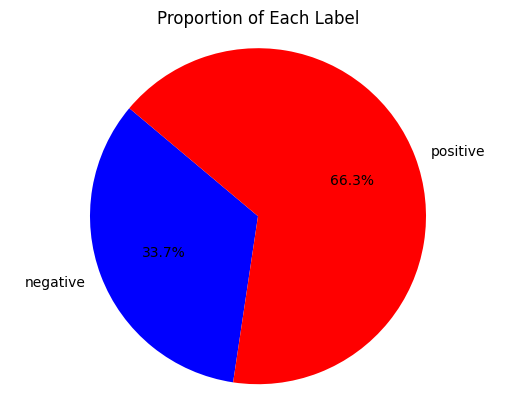

In [ ]:
# Check Positive vs Negative Ratio:
label_counts = Counter(df['label'])
labels = {0: 'negative', 1: 'positive'}

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['blue', 'red']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Proportion of Each Label')
plt.show()

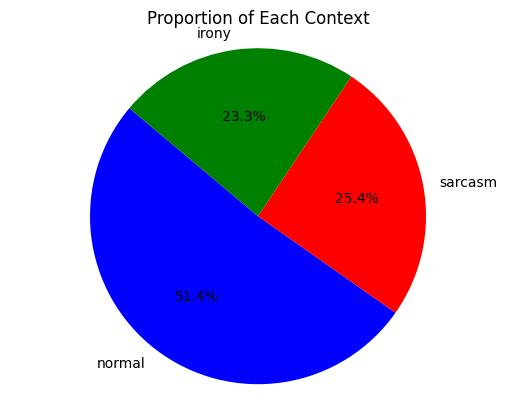

In [ ]:
# Check Context Ratio:
label_counts = Counter(df['Context'])
labels = {'Normal': 'normal', 'Sarcasm': 'sarcasm', 'Irony':'irony'}

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['blue', 'red', 'green']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Proportion of Each Context')
plt.show()

In [ ]:
# 5 examples of each tweet category possible, (positive vs negative), (Normal, Irony, Sarcasm)
unique_contexts = df['Context'].unique()

# Iterate over each unique context
for context in unique_contexts:
    print(f"Context: {context}")
    # Filter the DataFrame for the current context
    context_df = df[df['Context'] == context]
    # Filter positive tweets
    positive_tweets = context_df[context_df['label'] == 1]['text'].head(5)
    print("Positive Tweets:")
    for tweet in positive_tweets:
        print(tweet)
    # Filter negative tweets
    negative_tweets = context_df[context_df['label'] == 0]['text'].head(5)
    print("Negative Tweets:")
    for tweet in negative_tweets:
        print(tweet)
    print()

Context: Normal
Positive Tweets:
 Love starting my day with a cup of coffee and some good music! 
 Grateful for the sunny weather today, it's such a mood booster! 
 Just finished a great workout and feeling energized for the day ahead. 
 Spending time with loved ones always puts a smile on my face. 
 Excited to dive into a new book I've been waiting to read! 
Negative Tweets:
 Normal is overrated. 
 Can't stand being average, but that's what normal is all about. 
 Normal is just code for boring. 
 The idea of being normal makes me cringe. 
 Trying to fit in with the norm is exhausting. 

Context: Sarcasm
Positive Tweets:
 I just love when people take up two parking spots. So considerate. 
 I always look forward to getting stuck in traffic. It's the highlight of my day. 
 Ah, nothing like waking up to a pile of dirty dishes in the sink. Pure bliss. 
 Can't get enough of spam emails. They really brighten up my inbox. 
 Oh, I absolutely adore it when my phone dies right in the middle of a

In [ ]:
df['text_length'] = 0
df = clean_text(df)

train_data_generated = df["text"]
train_labels_generated = df["label"]

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_labels_generated).reshape(-1, 1)).toarray()

In [ ]:
X_train = np.array(train_data_generated)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)


Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/2



Epoch:   3%|▎         | 1/35 [00:21<12:01, 21.22s/it]

 1/35 [..............................] - ETA: 21:23 - loss: 0.7627 - recall_1: 0.4062 - precision_1: 0.4062


Epoch:   9%|▊         | 3/35 [00:38<06:18, 11.82s/it]

 2/35 [>.............................] - ETA: 7:30 - loss: 0.7042 - recall_1: 0.5312 - precision_1: 0.5312 


Epoch:  11%|█▏        | 4/35 [00:51<06:25, 12.45s/it]

 3/35 [=>............................] - ETA: 6:45 - loss: 0.6394 - recall_1: 0.6250 - precision_1: 0.6250


Epoch:  14%|█▍        | 5/35 [01:03<06:05, 12.19s/it]

 4/35 [==>...........................] - ETA: 6:22 - loss: 0.6043 - recall_1: 0.6484 - precision_1: 0.6484


Epoch:  17%|█▋        | 6/35 [01:15<05:48, 12.02s/it]

 5/35 [===>..........................] - ETA: 6:05 - loss: 0.5771 - recall_1: 0.6750 - precision_1: 0.6750


Epoch:  20%|██        | 7/35 [01:26<05:33, 11.93s/it]

 6/35 [====>.........................] - ETA: 6:16 - loss: 0.5474 - recall_1: 0.7031 - precision_1: 0.7031


Epoch:  23%|██▎       | 8/35 [01:43<05:58, 13.27s/it]

 7/35 [=====>........................] - ETA: 6:07 - loss: 0.5493 - recall_1: 0.7009 - precision_1: 0.7009


Epoch:  26%|██▌       | 9/35 [01:56<05:48, 13.41s/it]

 8/35 [=====>........................] - ETA: 6:03 - loss: 0.5401 - recall_1: 0.7109 - precision_1: 0.7109


Epoch:  29%|██▊       | 10/35 [02:12<05:51, 14.06s/it]

 9/35 [======>.......................] - ETA: 5:57 - loss: 0.5434 - recall_1: 0.7153 - precision_1: 0.7153


Epoch:  31%|███▏      | 11/35 [02:28<05:50, 14.60s/it]

10/35 [=======>......................] - ETA: 5:36 - loss: 0.5276 - recall_1: 0.7219 - precision_1: 0.7219


Epoch:  34%|███▍      | 12/35 [02:39<05:12, 13.58s/it]

11/35 [========>.....................] - ETA: 5:23 - loss: 0.5069 - recall_1: 0.7386 - precision_1: 0.7386


Epoch:  37%|███▋      | 13/35 [02:52<04:57, 13.50s/it]

12/35 [=========>....................] - ETA: 5:12 - loss: 0.5014 - recall_1: 0.7526 - precision_1: 0.7526


Epoch:  40%|████      | 14/35 [03:07<04:53, 13.95s/it]

13/35 [==========>...................] - ETA: 5:04 - loss: 0.4899 - recall_1: 0.7644 - precision_1: 0.7644


Epoch:  43%|████▎     | 15/35 [03:24<04:53, 14.66s/it]

14/35 [===========>..................] - ETA: 4:50 - loss: 0.4773 - recall_1: 0.7723 - precision_1: 0.7723


Epoch:  46%|████▌     | 16/35 [03:38<04:35, 14.49s/it]

15/35 [===========>..................] - ETA: 4:42 - loss: 0.4761 - recall_1: 0.7708 - precision_1: 0.7708


Epoch:  49%|████▊     | 17/35 [03:55<04:36, 15.39s/it]

16/35 [============>.................] - ETA: 4:36 - loss: 0.4739 - recall_1: 0.7695 - precision_1: 0.7695


Epoch:  51%|█████▏    | 18/35 [04:16<04:48, 16.96s/it]

17/35 [=============>................] - ETA: 4:26 - loss: 0.4685 - recall_1: 0.7757 - precision_1: 0.7757


Epoch:  54%|█████▍    | 19/35 [04:34<04:38, 17.38s/it]

18/35 [==============>...............] - ETA: 4:13 - loss: 0.4582 - recall_1: 0.7830 - precision_1: 0.7830


Epoch:  57%|█████▋    | 20/35 [04:51<04:17, 17.18s/it]

19/35 [===============>..............] - ETA: 4:07 - loss: 0.4502 - recall_1: 0.7878 - precision_1: 0.7878


Epoch:  60%|██████    | 21/35 [05:16<04:34, 19.60s/it]

20/35 [================>.............] - ETA: 3:53 - loss: 0.4452 - recall_1: 0.7906 - precision_1: 0.7906


Epoch:  63%|██████▎   | 22/35 [05:34<04:07, 19.06s/it]

21/35 [=================>............] - ETA: 3:39 - loss: 0.4366 - recall_1: 0.7946 - precision_1: 0.7946


Epoch:  66%|██████▌   | 23/35 [05:52<03:44, 18.70s/it]

22/35 [=================>............] - ETA: 3:23 - loss: 0.4252 - recall_1: 0.8011 - precision_1: 0.8011


Epoch:  69%|██████▊   | 24/35 [06:06<03:10, 17.31s/it]

23/35 [==================>...........] - ETA: 3:07 - loss: 0.4240 - recall_1: 0.8043 - precision_1: 0.8043


Epoch:  71%|███████▏  | 25/35 [06:22<02:50, 17.01s/it]

24/35 [===================>..........] - ETA: 2:51 - loss: 0.4199 - recall_1: 0.8060 - precision_1: 0.8060


Epoch:  74%|███████▍  | 26/35 [06:37<02:26, 16.28s/it]

25/35 [====================>.........] - ETA: 2:37 - loss: 0.4122 - recall_1: 0.8112 - precision_1: 0.8112


Epoch:  77%|███████▋  | 27/35 [06:55<02:15, 17.00s/it]

26/35 [=====================>........] - ETA: 2:21 - loss: 0.4096 - recall_1: 0.8113 - precision_1: 0.8113


Epoch:  80%|████████  | 28/35 [07:11<01:56, 16.63s/it]

27/35 [======================>.......] - ETA: 2:07 - loss: 0.4004 - recall_1: 0.8171 - precision_1: 0.8171


Epoch:  83%|████████▎ | 29/35 [07:31<01:44, 17.46s/it]

28/35 [=======================>......] - ETA: 1:52 - loss: 0.3941 - recall_1: 0.8203 - precision_1: 0.8203


Epoch:  86%|████████▌ | 30/35 [07:50<01:30, 18.04s/it]

29/35 [=======================>......] - ETA: 1:36 - loss: 0.3885 - recall_1: 0.8222 - precision_1: 0.8222


Epoch:  89%|████████▊ | 31/35 [08:06<01:09, 17.43s/it]

30/35 [========================>.....] - ETA: 1:19 - loss: 0.3835 - recall_1: 0.8250 - precision_1: 0.8250


Epoch:  91%|█████████▏| 32/35 [08:21<00:50, 16.79s/it]

31/35 [=========================>....] - ETA: 1:03 - loss: 0.3761 - recall_1: 0.8296 - precision_1: 0.8296


Epoch:  94%|█████████▍| 33/35 [08:37<00:32, 16.31s/it]

32/35 [==========================>...] - ETA: 47s - loss: 0.3702 - recall_1: 0.8330 - precision_1: 0.8330 


Epoch:  97%|█████████▋| 34/35 [08:53<00:16, 16.35s/it]

33/35 [===========================>..] - ETA: 31s - loss: 0.3643 - recall_1: 0.8352 - precision_1: 0.8352


Epoch: 100%|██████████| 35/35 [09:07<00:00, 15.66s/it]

34/35 [============================>.] - ETA: 16s - loss: 0.3620 - recall_1: 0.8364 - precision_1: 0.8364


Epoch: 36it [09:29, 17.61s/it]                        

35/35 [==============================] - 591s 16s/step - loss: 0.3563 - recall_1: 0.8402 - precision_1: 0.8402
Epoch 2/2



Epoch: 37it [09:51, 18.80s/it]

 1/35 [..............................] - ETA: 3:10 - loss: 0.3992 - recall_1: 0.8000 - precision_1: 0.8000


Epoch: 38it [09:56, 14.84s/it]

 2/35 [>.............................] - ETA: 6:29 - loss: 0.1756 - recall_1: 0.9362 - precision_1: 0.9362


Epoch: 39it [10:08, 13.92s/it]

 3/35 [=>............................] - ETA: 6:43 - loss: 0.1673 - recall_1: 0.9367 - precision_1: 0.9367


Epoch: 40it [10:22, 13.78s/it]

 4/35 [==>...........................] - ETA: 7:37 - loss: 0.1884 - recall_1: 0.9369 - precision_1: 0.9369


Epoch: 41it [10:41, 15.35s/it]

 5/35 [===>..........................] - ETA: 8:14 - loss: 0.1766 - recall_1: 0.9371 - precision_1: 0.9371


Epoch: 42it [11:02, 17.24s/it]

 6/35 [====>.........................] - ETA: 8:33 - loss: 0.1802 - recall_1: 0.9371 - precision_1: 0.9371


Epoch: 43it [11:25, 18.88s/it]

 7/35 [=====>........................] - ETA: 8:12 - loss: 0.1866 - recall_1: 0.9324 - precision_1: 0.9324


Epoch: 44it [11:42, 18.31s/it]

 8/35 [=====>........................] - ETA: 7:52 - loss: 0.1867 - recall_1: 0.9331 - precision_1: 0.9331


Epoch: 45it [11:59, 17.88s/it]

 9/35 [======>.......................] - ETA: 7:49 - loss: 0.1923 - recall_1: 0.9299 - precision_1: 0.9299


Epoch: 46it [12:21, 19.10s/it]

10/35 [=======>......................] - ETA: 7:29 - loss: 0.1846 - recall_1: 0.9373 - precision_1: 0.9373


Epoch: 47it [12:38, 18.58s/it]

11/35 [========>.....................] - ETA: 7:06 - loss: 0.1951 - recall_1: 0.9254 - precision_1: 0.9254


Epoch: 48it [12:54, 17.73s/it]

12/35 [=========>....................] - ETA: 6:47 - loss: 0.1900 - recall_1: 0.9264 - precision_1: 0.9264


Epoch: 49it [13:11, 17.66s/it]

13/35 [==========>...................] - ETA: 6:32 - loss: 0.1915 - recall_1: 0.9248 - precision_1: 0.9248


Epoch: 50it [13:31, 18.15s/it]

14/35 [===========>..................] - ETA: 6:15 - loss: 0.2006 - recall_1: 0.9234 - precision_1: 0.9234


Epoch: 51it [13:49, 18.24s/it]

15/35 [===========>..................] - ETA: 5:58 - loss: 0.1970 - recall_1: 0.9266 - precision_1: 0.9266


Epoch: 52it [14:08, 18.33s/it]

16/35 [============>.................] - ETA: 5:44 - loss: 0.1921 - recall_1: 0.9293 - precision_1: 0.9293


Epoch: 53it [14:28, 18.93s/it]

17/35 [=============>................] - ETA: 5:25 - loss: 0.1951 - recall_1: 0.9260 - precision_1: 0.9260


Epoch: 54it [14:46, 18.66s/it]

18/35 [==============>...............] - ETA: 5:05 - loss: 0.1872 - recall_1: 0.9302 - precision_1: 0.9302


Epoch: 55it [15:02, 17.93s/it]

19/35 [===============>..............] - ETA: 4:41 - loss: 0.1969 - recall_1: 0.9255 - precision_1: 0.9255


Epoch: 56it [15:13, 15.86s/it]

20/35 [================>.............] - ETA: 4:22 - loss: 0.1985 - recall_1: 0.9246 - precision_1: 0.9246


Epoch: 57it [15:29, 15.90s/it]

21/35 [=================>............] - ETA: 4:04 - loss: 0.2053 - recall_1: 0.9176 - precision_1: 0.9176


Epoch: 58it [15:46, 16.24s/it]

22/35 [=================>............] - ETA: 3:49 - loss: 0.1970 - recall_1: 0.9214 - precision_1: 0.9214


Epoch: 59it [16:07, 17.58s/it]

23/35 [==================>...........] - ETA: 3:32 - loss: 0.1959 - recall_1: 0.9235 - precision_1: 0.9235


Epoch: 60it [16:25, 17.73s/it]

24/35 [===================>..........] - ETA: 3:13 - loss: 0.1944 - recall_1: 0.9241 - precision_1: 0.9241


Epoch: 61it [16:42, 17.47s/it]

25/35 [====================>.........] - ETA: 2:58 - loss: 0.1886 - recall_1: 0.9259 - precision_1: 0.9259


Epoch: 62it [17:04, 18.74s/it]

26/35 [=====================>........] - ETA: 2:39 - loss: 0.1886 - recall_1: 0.9264 - precision_1: 0.9264


Epoch: 63it [17:18, 17.52s/it]

27/35 [======================>.......] - ETA: 2:19 - loss: 0.1875 - recall_1: 0.9268 - precision_1: 0.9268


Epoch: 64it [17:30, 15.70s/it]

28/35 [=======================>......] - ETA: 2:00 - loss: 0.1819 - recall_1: 0.9295 - precision_1: 0.9295


Epoch: 65it [17:41, 14.40s/it]

29/35 [=======================>......] - ETA: 1:41 - loss: 0.1852 - recall_1: 0.9276 - precision_1: 0.9276


Epoch: 66it [17:52, 13.28s/it]

30/35 [========================>.....] - ETA: 1:23 - loss: 0.1833 - recall_1: 0.9290 - precision_1: 0.9290


Epoch: 67it [18:03, 12.61s/it]

31/35 [=========================>....] - ETA: 1:06 - loss: 0.1799 - recall_1: 0.9303 - precision_1: 0.9303


Epoch: 68it [18:14, 12.25s/it]

32/35 [==========================>...] - ETA: 49s - loss: 0.1808 - recall_1: 0.9295 - precision_1: 0.9295 


Epoch: 69it [18:26, 12.02s/it]

33/35 [===========================>..] - ETA: 32s - loss: 0.1783 - recall_1: 0.9307 - precision_1: 0.9307


Epoch: 70it [18:37, 11.85s/it]

34/35 [============================>.] - ETA: 16s - loss: 0.1789 - recall_1: 0.9309 - precision_1: 0.9309


Epoch: 71it [18:49, 11.78s/it]

35/35 [==============================] - 550s 16s/step - loss: 0.1801 - recall_1: 0.9275 - precision_1: 0.9275


In [ ]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

7/7 [==============================] - 23s 3s/step


In [ ]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "LLM - Generated Data")
metrics_val.plot()

Comment GPT generated data...
Remember limitations -> might end up in a loop of the same tweets generated over and over again. No negative sarcasm.

In [ ]:
#Zero shot with LLM, select few tweets from validation set, sent them to GPT and ask him to label them, then use this labled data to train the model (as we have the labels of the validation set we can also see how well GPT performed)
#Zero shot learning in NN, pre-train model on sample from the validation set, then train on the whole train data
#GPT_tweet in NN, pre-train model on gpt_tweets, then train on the whole train data

## Pre-train the (freezed) model with the different techniques explored before

In [ ]:
# Apply the different techniques and compare their perfromance
techniques = [[train_data_32,train_labels_32], [augmented_df_data,augmented_df_label] ,[train_data_generated,train_labels_generated]] # 1. 32 label, 2. Synonyms, 3. Zero Shot, 4. LLM Tweets

metrics_techniques = Metrics()

In [ ]:
for data, labels in techniques:
    print(type(data))
    print(type(labels))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Model : 1
Fit Freezed layer...
Epoch 1/2


1/1 [==============================] - 18s 18s/step - loss: 0.5249 - recall_8: 0.7500 - precision_8: 0.7500
Epoch 2/2
7/7 [==============================] - 34s 4s/step
Fit unfreezd layer...
Epoch 1/3


31/31 [==============================] - 387s 12s/step - loss: 0.8135 - recall_9: 0.4889 - precision_9: 0.4889
Epoch 2/3
31/31 [==============================] - 351s 12s/step - loss: 0.7042 - recall_9: 0.5372 - precision_9: 0.5372
Epoch 3/3
7/7 [==============================] - 23s 3s/step
Model : 1
Fit Freezed layer...
Epoch 1/2
2/2 [==============================] - 17s 3s/step - loss: 0.5679 - recall_10: 0.7969 - precision_10: 0.7969
Epoch 2/2
7/7 [==============================] - 23s 3s/step
Fit unfreezd layer...
Epoch 1/3
31/31 [==============================] - 386s 12s/step - loss: 0.6749 - recall_11: 0.5746 - precision_11: 0.5746
Epoch 2/3
31/31 [==============================] - 352s 12s/step - loss: 0.6161 - recall_11: 0.6746 - precision_11: 0.6746
Epoch 3/3
7/7 [==============================] - 24s 3s/step
Model : 1
Fit Freezed layer...
Epoch 1/2
35/35 [==============================] - 132s 4s/step - loss: 0.2917 - recall_12: 0.8652 - precision_12: 0.8652
Epoch 2/2
7/7 

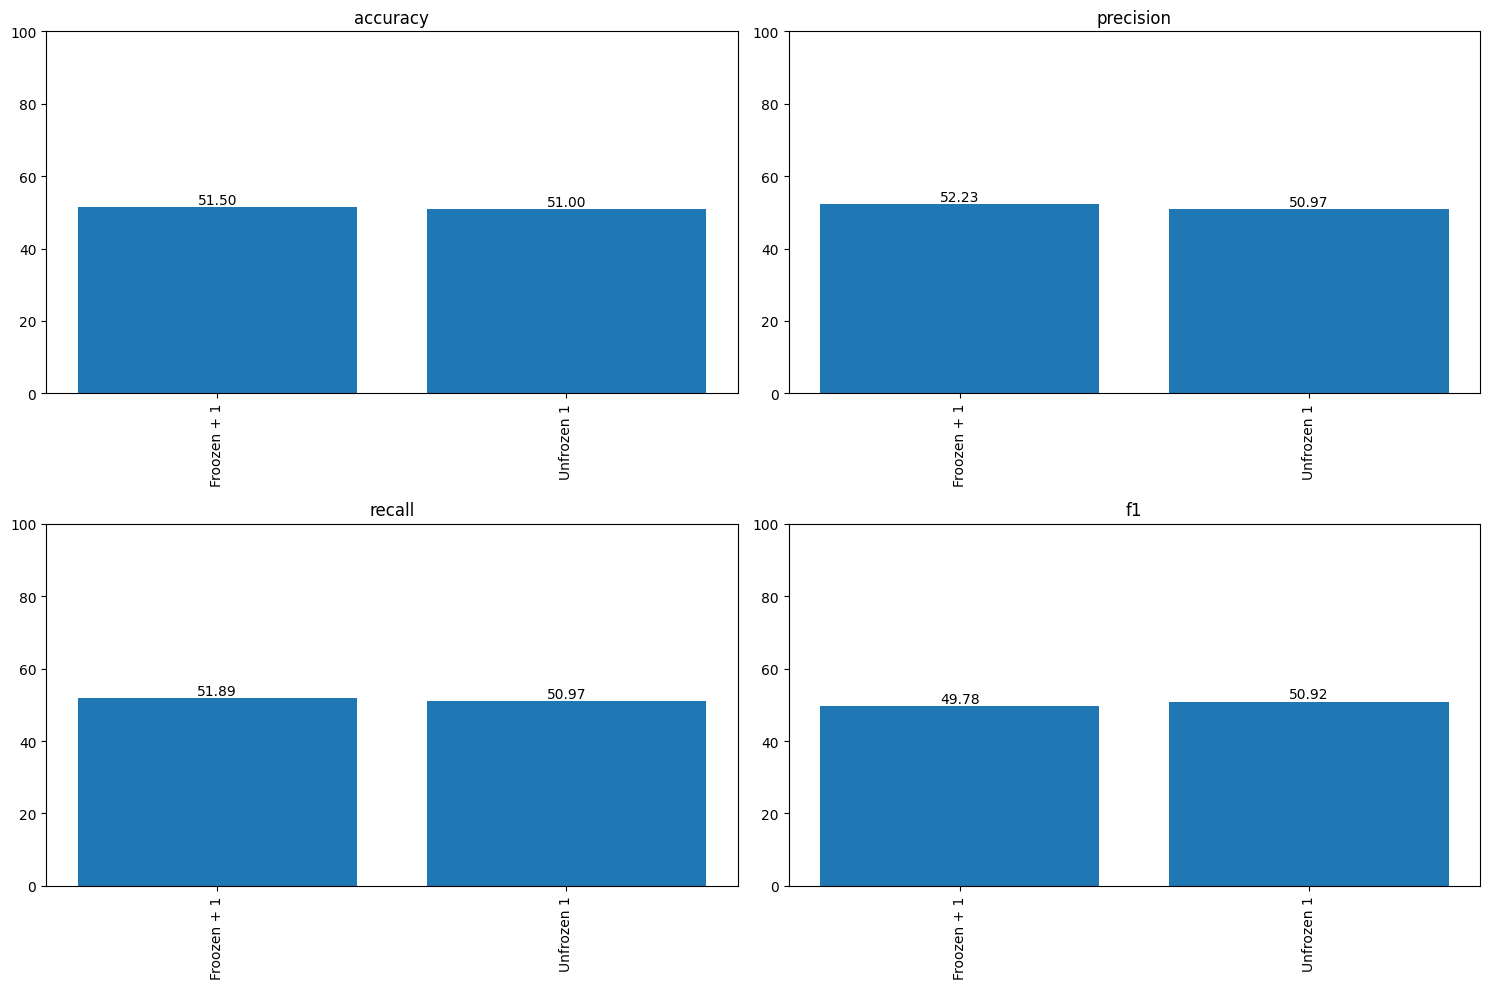

In [ ]:
histories = []

for train_tec,y_tec in techniques:
    i = 1
    print("Model :",i)
    bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)
    # To freeze BERT parameters (look at the trainable parameters below)
    bert_model.layers[2].trainable = False

    X_train = np.array(train_tec)

    enc = OneHotEncoder(handle_unknown='ignore')
    y_train = enc.fit_transform(np.array(y_tec).reshape(-1, 1)).toarray()

    steps_per_epoch = int(len(X_train)/batch_size)

    batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

    bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

    print("Fit Freezed layer...")
    bert_model.fit(batches, epochs=2, steps_per_epoch=steps_per_epoch)

    # Test the model
    inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                        add_special_tokens=True, max_length=max_length,
                                        padding='max_length',  return_attention_mask=True,
                                        return_token_type_ids=True, truncation=True)

    # Extract input_ids and attention mask
    inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
                  np.asarray(inputs['attention_mask'], dtype='int32')]

    test_preds = bert_model.predict(inputs_test)
    test_preds = np.argmax(test_preds, axis=1)

    # get the final metrics
    metrics_techniques.run(test_labels, test_preds, f"Froozen + {i}")

    print("Fit unfreezd layer...")
    bert_model.layers[2].trainable = True

    steps_per_epoch = int(len(train_data)/batch_size)
    X_train = np.array(train_data_clean)

    enc = OneHotEncoder(handle_unknown='ignore')
    y_train = enc.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()

    # Train on the whole NN
    batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

    bert_model.compile(optimizer=Adam(2e-5),
                      metrics=[tf.keras.metrics.Recall(),
                      tf.keras.metrics.Precision()],
                      loss=tf.keras.losses.CategoricalCrossentropy())

    bert_model.fit(batches, epochs=3, steps_per_epoch=steps_per_epoch)

    # Get the inputs tokenized from the test set
    inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                        add_special_tokens=True, max_length=max_length,
                                        padding='max_length',  return_attention_mask=True,
                                        return_token_type_ids=True, truncation=True)

    # Extract input_ids and attention mask
    inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
                  np.asarray(inputs['attention_mask'], dtype='int32')]
    test_preds = bert_model.predict(inputs_test)
    test_preds = np.argmax(test_preds, axis=1)

    # get the final metrics
    metrics_techniques.run(test_labels, test_preds, f"Unfrozen {i}")

metrics_techniques.plot()